# Importación de las librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date,timedelta
import statistics
import plotly.express as px
import six

In [ ]:
#Creación de la ruta donde estarán guardadas las gráficas
!mkdir figs

# Lectura de las base de datos

Se está tomando la base de datos publicada en Open Data Colombia por la INS, la cual se actualizará con los datos más recientes cada vez que se ejecute el código.


In [ ]:
covid = pd.read_csv("https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv", sep=",", encoding='utf-8')
covid.head()

La base de datos contiene la información individual por persona, donde cada observación es un caso confirmado. Además contiene la fecha de recuperación para las personas ya recuperadas, la fecha de muerte para las personas fallecidas, y las fechas de inicio de síntomas, fecha de diagnóstico y la fecha en que se notificó el caso.

In [ ]:
# Dimensión de las bases de datos
covid.shape

### Depuración de los datos

Se crea una copia de la base de datos original descargada y a esta se le aplican las siguientes acciones:
- Eliminación de caracteres especiales como tíldes, virgulillas, diéresis, entre otros. 
- LLevar a formato fecha de Python las columnas con fecha de las base de datos.
- Eliminar espacios en las valores de las columnas.
- Se estandarizan los valores de la columna "Atención"
- Los valores que en la columna "Atención" aparecen en NaN quieren decir que no se tiene información de recuperación, muerte y demás. Por lo tanto estos fueron clasificados como "Fallecidos" quienes tiene fecha de muerte, y "Activos" quienes no la tienen.

In [ ]:
#Creamos una copia del dataset
df = covid.copy()
#Función para eliminar caracteres especiales
import unicodedata
def car_espe(lista):
    return(unicodedata.normalize('NFKD', lista).encode('ascii', 'ignore').decode('utf-8', 'ignore'))

#Se eliminan caracteres especiales y espacios atrás y adelante de los encabezados
df.columns = [car_espe(h).strip() for h in df.columns]

#Cambio a formato de fecha de la Fecha de notificación
df['Fecha de notificacion'] = pd.to_datetime([f.split('T')[0] for f in df['Fecha de notificacion']])
df['Fecha de muerte'] = pd.to_datetime([f[:10] for f in df['Fecha de muerte'].astype(str)])
df['Fecha recuperado'] = pd.to_datetime([f[:10] for f in df['Fecha recuperado'].astype(str)])

df = df.sort_values('Fecha de notificacion')

# Los valores con "nan" en la columna Atención corresponden a los casos de los cuales no se tiene información
#pero son tomados como casos confirmados por lo tanto se tomarán como casos activos
#Ajuste de los nan en Atención por activos o fallecidos
for i in df.index:
    if pd.isnull(df['atencion'][i]):
        if pd.isnull(df['Fecha de muerte'][i]):
            df['atencion'][i] = 'Activo'
        else:
            df['atencion'][i] = 'Fallecido'

#Eliminar caracteres especiales del nombre de la ciudad y del departamento
df['Ciudad de ubicacion'] = [car_espe(f).strip().replace('.','') for f in df['Ciudad de ubicacion']]
df['Departamento o Distrito'] = [car_espe(f).strip() for f in df['Departamento o Distrito']]

df['atencion'] = [f.capitalize().strip() for f in df['atencion']]

df = df[['Fecha de notificacion','Fecha de muerte','Fecha recuperado','Ciudad de ubicacion','atencion','Edad','Sexo']]
df.columns = ['fecha_notificacion','fecha_muerte','fecha_recuperado','ciudad','atencion','edad','sexo']
df.tail()

###### Histogramas de frecuencia del número de casos confirmados para Colombia y sus 5 principales ciudades

In [ ]:
#Las gráficas quedan guardadas en la ruta fig/histogramas_edad/
ciudades = ['Colombia', 'Bogota DC', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']
for i in ciudades:
    if i == "Colombia":
        ciu = df.copy()
    else:
        ciu = df[df['ciudad'] == i]
    
    fig, ax = plt.subplots(1, figsize=(8, 6))
    fig.suptitle('Distribución de casos confirmados por edad en ' + str(i), fontsize=15)
    ax.hist(ciu['edad'], bins=20)
    fig = plt.savefig('figs/' + 'edad_' + str(i) + '.png')

# Construcción del Modelo SIRM a partir de los datos y los pronósticos

<p>La función que se define contruye una tabla con el número de infectados para cada día con una media móvil de 7 días, esto con el fin de suavizar un poco la curva de los casos confirmados (el procedimiento se realiza de la misma forma para los recuperados y los fallecidos). Además, construye el numero de casos activos por días y el número de personas susceptibles al contagio. También hace el cálculo del Beta (tasa de infección), Gamma (tasa de recuperación) y Delta (tasa de muerte) para cada uno de los días. A partir de los valores mencionados se realizará el pronóstico.</p>

<p>La función toma como entradas un DataFrame, el nombre de la ciudad para la cual se va a hacer la construcción, el tiempo para el pronóstico y el escenario de los parámetros de los Betas que son:</p>

- last_param: último parámetro calculado con los datos de la base.
- last_param_cal: se calculan los parámetros con los valores de los pronósticos y se toma este último.
- prom_param: toma el promedio de los últimos 7 días de los parámetros calculados con los datos de la base.


In [ ]:
# Población de las Colombia y las ciudades que se desean modelar
poblacion = {'Colombia': 50882884, 'Bogota DC': 7743955, 'Medellin': 2933094, 'Cartagena de Indias': 1028736,
             'Cali': 2497562, 'Barranquilla': 1243113}

#Ingresa el DataFrame del COVID-19 (definido como df) y el entre comillas el nombre de la ciudad a calcular
def data_sirm_pron(df, ciudad, periodo_pronostico, cal_parametros):
    
    #Filtro de la ciudad a revisar
    if ciudad == "Colombia":
        df1 = df.copy()
    else:
        df1 = df[df['ciudad'] == ciudad]

    #Dataframe predefinido con el listado de fechas
    df_fecha = pd.DataFrame(np.unique(df1['fecha_notificacion']))
    df_fecha.columns = ['fecha']    

    # Cálculo del número de infectados por día
    df_sirm = df1.groupby(['fecha_notificacion'], as_index=False)['atencion'].count()
    df_sirm.columns = ['fecha','infectados']
    # Cálculo del promedio móvil de 7 días del número de infectados por día y el acumulado
    df_sirm['infectados'] = df_sirm['infectados'].rolling(7).mean()
    df_sirm = df_sirm.dropna()
    df_sirm['infectados_acum'] = df_sirm['infectados'].cumsum()

    # Cálculo del número de infectados recuperados por día, el promedio móvil de 7 días y el acumulado
    df_recu = df1[df1['atencion'] == 'Recuperado'].groupby(['fecha_recuperado'], as_index=False)['atencion'].count()
    df_recu.columns = ['fecha','recuperados']
    df_recu = df_fecha.merge(df_recu, on='fecha', how='left')
    df_recu['recuperados'].fillna(0, inplace=True) #Reemplaza los NaN por 0
    df_recu['recuperados'] = df_recu['recuperados'].rolling(7).mean() #promedio móvil de 7 días
    df_recu['recuperados_acum'] = df_recu['recuperados'].cumsum() #acumulado

    # Concatenando la infromación de recuperado en la base de df_sirm
    df_sirm = df_sirm.merge(df_recu, on='fecha', how='left')

    # Cálculo del número de infectados muertos por día, el promedio móvil de 7 días y el acumulado
    df_muerto = df1[df1['atencion'] == 'Fallecido'].groupby(['fecha_muerte'], as_index=False)['atencion'].count()
    df_muerto.columns = ['fecha','fallecidos']
    df_muerto = df_fecha.merge(df_muerto, on='fecha', how='left')
    df_muerto['fallecidos'].fillna(0, inplace=True) #Reemplaza los NaN por 0
    df_muerto['fallecidos'] = df_muerto['fallecidos'].rolling(7).mean() #promedio móvil de 7 días
    df_muerto['fallecidos_acum'] = df_muerto['fallecidos'].cumsum() #acumulado

    # Concatenando la información de fallecidos en la base de df_sirm
    df_sirm = df_sirm.merge(df_muerto, on='fecha', how='left')
    
    # Obtención de los betas, gammas y deltas
    N = poblacion.get(ciudad) #Obtiene el total de la población de acuerdo a la ciudad definida en el diccionario
    
    # N = Total de la población
    # S = Susceptibles
    # I = Infectados
    # R = Recuperados
    # F = Fallecidos
    # A = Infectados activos
    df_sirm['activos'] = df_sirm['suceptibles'] = df_sirm['beta'] = df_sirm['gamma'] = df_sirm['delta'] = float()
    df_sirm['description'] = ""

##################################################
# Construcción de la tabla del SIRM con los datos #

    for t in range(len(df_sirm['fecha'])):
        #print(t)
        df_pron = pd.DataFrame()
        
        if t == 0:
            df_sirm['activos'][t] = df_sirm['infectados'][t] #Activos en el dia 0 son los contagiados ese dia
            df_sirm['suceptibles'][t] = N - df_sirm['infectados'][t] #Sucetibles en el día 0 es total de la poblacion menos los contagiados en ese dia
            df_sirm['beta'][t] = df_sirm['gamma'][t] = df_sirm['delta'][t] = 0
            df_sirm['description'] = "Real" 
            
        else:
            # A(t) = A(t-1) + I(t) - R(t) - F(t)
            df_sirm['activos'][t] = df_sirm['activos'][t-1] + df_sirm['infectados'][t] - df_sirm['recuperados'][t] - df_sirm['fallecidos'][t]
            # S(t) = S(t-1) - I(t)
            df_sirm['suceptibles'][t] = df_sirm['suceptibles'][t-1] - df_sirm['infectados'][t]
            # beta = (I(t) * N)/(A(t-1)*S(t-1))
            df_sirm['beta'][t] = (df_sirm['infectados'][t] * N) / (df_sirm['activos'][t-1] * df_sirm['suceptibles'][t-1])
            # gamma = R(t) / A(t-1)
            df_sirm['gamma'][t] = df_sirm['recuperados'][t] / df_sirm['activos'][t-1]
            # delta = F(t) / A(t-1)
            df_sirm['delta'][t] = df_sirm['fallecidos'][t] / df_sirm['activos'][t-1]
            df_sirm['description'] = "Real"
            
# Fin de la construcción de la tabla del modelo SIRM con los datos #
###################################################################
    
    df_param = df_sirm.copy()
    
    for i in range(len(df_param['fecha']), len(df_param['fecha']) + periodo_pronostico):
        df_pron = pd.DataFrame()

        if cal_parametros == 'last_param': # último parámetro calculado con los datos
            beta = df_param['beta'].iloc[-1]
            gamma = df_param['gamma'].iloc[-1]
            delta = df_param['delta'].iloc[-1]        
        
        elif cal_parametros == 'last_param_cal': # último dato calculado
            beta = df_sirm['beta'].iloc[-1]
            gamma = df_sirm['gamma'].iloc[-1]
            delta = df_sirm['delta'].iloc[-1]
            
        else: #Promedio últimos 7 días calculado con los datos
            beta = df_param['beta'][-7:].mean()
            gamma = df_param['gamma'][-7:].mean()
            delta = df_param['delta'][-7:].mean()


        #Cálculo de los pronósticos
        df_pron['fecha'] = [pd.to_datetime(df_sirm['fecha'][i-1] + timedelta(days = 1))]

        # I(t) = (beta * A(t-1) * S(t-1)) / N
        if df_sirm['infectados_acum'][i-1] >= N:
            df_pron['infectados'] = [0]
        else:
            df_pron['infectados'] = [((beta * df_sirm['activos'][i-1] * df_sirm['suceptibles'][i-1]) / N)]            
         
        
        df_pron['infectados_acum'] = [df_sirm['infectados_acum'][i-1] + df_pron['infectados'][0]]
        # R(t) = A(t-1) * gamma
        df_pron['recuperados'] = [df_sirm['activos'][i-1] * gamma]
        df_pron['recuperados_acum'] = [df_sirm['recuperados_acum'][i-1] + df_pron['recuperados'][0]]

        # F(t) = A(t-1) * delta
        df_pron['fallecidos'] = [df_sirm['activos'][i-1] * delta]
        df_pron['fallecidos_acum'] = [df_sirm['fallecidos_acum'][i-1] + df_pron['fallecidos'][0]]

        # A(t) = A(t-1) + I(t) - R(t) - F(t)
        df_pron['activos'] = [df_sirm['activos'][i-1] + df_pron['infectados'][0] - df_pron['recuperados'][0] - df_pron['fallecidos'][0]]

        # S(t) = S(t-1) - I(t)
        df_pron['suceptibles'] = [df_sirm['suceptibles'][i-1] - df_pron['infectados'][0]]
        
        if cal_parametros == 'last_param': # último parámetro calculado con los datos        
            df_pron['beta'] = beta
            df_pron['gamma'] = gamma
            df_pron['delta'] = delta
        elif cal_parametros == 'last_param_cal': # último dato calculado
            df_pron['beta'] = (df_pron['infectados'][0] * N) / (df_sirm['activos'][t-1] * df_sirm['suceptibles'][t-1])
            # gamma = R(t) / A(t-1)
            df_pron['gamma'] = df_pron['recuperados'][0] / df_sirm['activos'][t-1]
            # delta = F(t) / A(t-1)
            df_pron['delta'] = df_pron['fallecidos'][0] / df_sirm['activos'][t-1]
        else:
            df_pron['beta'] = beta
            df_pron['gamma'] = gamma
            df_pron['delta'] = delta
            
        df_pron['description'] = 'Pronostico'
        
        df_sirm = df_sirm.append(df_pron).reset_index(drop=True)

    # Retorna un data frame
    return df_sirm  

### Construcción de los pronósticos a 15 días y los intervalos de confianza

In [ ]:
ciudades = list(poblacion.keys())
ciudad = ['Colombia', 'Bogota DC', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']
periodo_pronostico = [15,30]
cal_parametros = ['last_param', 'last_param_cal', 'prom_param']

df_pron15 = pd.DataFrame()
for ciudad in ciudades:
    
    for param in cal_parametros:
        
        df_calculo = data_sirm_pron(df, ciudad, periodo_pronostico[0], param)
        df_calculo['ciudad'] = ciudad
        df_calculo['escenario'] = param
        df_calculo = df_calculo[['fecha','ciudad','escenario','suceptibles','infectados','recuperados','fallecidos','activos','description']]
        
        #columnas con los pronósticos
        df_calculo['pronostico_infectados'] = df_calculo['infectados']
        df_calculo['pronostico_recuperados'] = df_calculo['recuperados']
        df_calculo['pronostico_fallecidos'] = df_calculo['fallecidos']
        df_calculo['pronostico_activos'] = df_calculo['activos']
        
        df_calculo['ICi_infectados'] = df_calculo['infectados']
        df_calculo['ICs_infectados'] = df_calculo['infectados']
        df_calculo['ICi_recuperados'] = df_calculo['recuperados']
        df_calculo['ICs_recuperados'] = df_calculo['recuperados']
        df_calculo['ICi_fallecidos'] = df_calculo['fallecidos']
        df_calculo['ICs_fallecidos'] = df_calculo['fallecidos']
        df_calculo['ICi_activos'] = df_calculo['activos']
        df_calculo['ICs_activos'] = df_calculo['activos']
        
        #datos pronósticos
        df_cal1 = df_calculo.iloc[-15:,:]
        
        #datos sin pronósticos
        df_calculo = df_calculo.iloc[:-15,:]
        
        df_pron = df_calculo.iloc[:-15,:]
        
        #cálculo IC
        df_cal1['ICi_infectados'] = df_cal1['infectados'] - statistics.stdev(df_cal1['infectados'])
        df_cal1['ICs_infectados'] = df_cal1['infectados'] + statistics.stdev(df_cal1['infectados']) 
        
        df_cal1['ICi_recuperados'] = df_cal1['recuperados'] - statistics.stdev(df_cal1['recuperados'])
        df_cal1['ICs_recuperados'] = df_cal1['recuperados'] + statistics.stdev(df_cal1['recuperados'])
        
        df_cal1['ICi_fallecidos'] = df_cal1['fallecidos'] - statistics.stdev(df_cal1['fallecidos'])
        df_cal1['ICs_fallecidos'] = df_cal1['fallecidos'] + statistics.stdev(df_cal1['fallecidos'])
        
        df_cal1['ICi_activos'] = df_cal1['activos'] - statistics.stdev(df_cal1['activos'])
        df_cal1['ICs_activos'] = df_cal1['activos'] + statistics.stdev(df_cal1['activos'])
        
        df_calculo = df_calculo.append(df_cal1)
        
        # últimos valores de infectados, recuperados, fallecidos y activos
        ajuste = ['infectados','recuperados','fallecidos','activos']
        
        for f in range(len(df_calculo['infectados'][:-15]),len(df_calculo['infectados'])):
            df_calculo['infectados'][f] = None
        
        for f in range(len(df_calculo['recuperados'][:-15]),len(df_calculo['recuperados'])):
            df_calculo['recuperados'][f] = None
            
        for f in range(len(df_calculo['fallecidos'][:-15]),len(df_calculo['fallecidos'])):
            df_calculo['fallecidos'][f] = None
            
        for f in range(len(df_calculo['activos'][:-15]),len(df_calculo['activos'])):
            df_calculo['activos'][f] = None
        
        df_pron15 = pd.concat([df_pron15,df_calculo])


In [ ]:
df_pron15.tail(20)

In [ ]:
prueba = df_pron15[(df_pron15['ciudad']== 'Bogota DC') & (df_pron15['escenario']== param)]
prueba.head()

##### Gráficas con los pronósticos a 15 días y los IC para cada uno de los estados

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



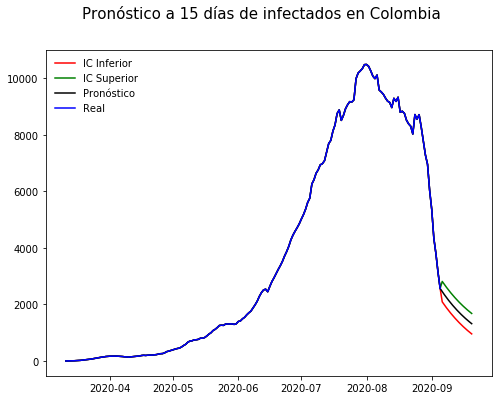

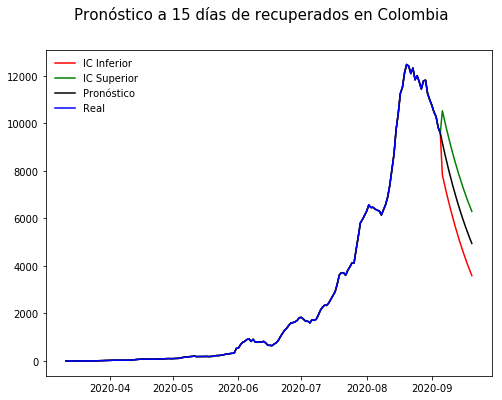

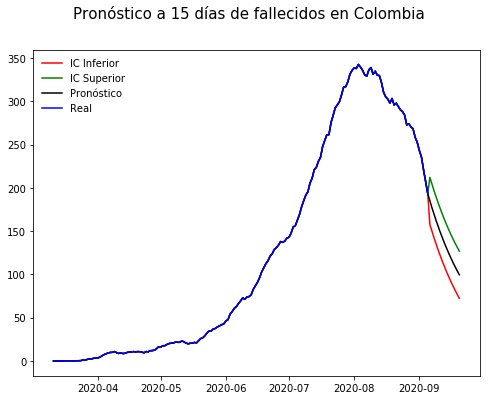

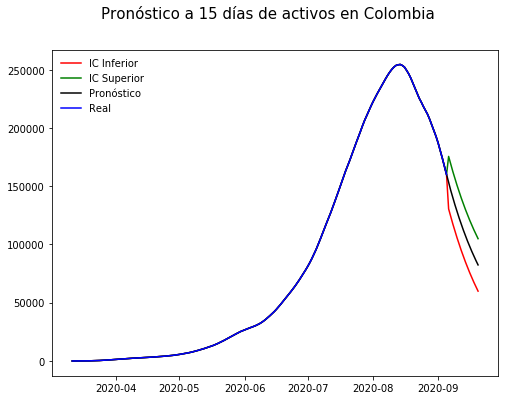

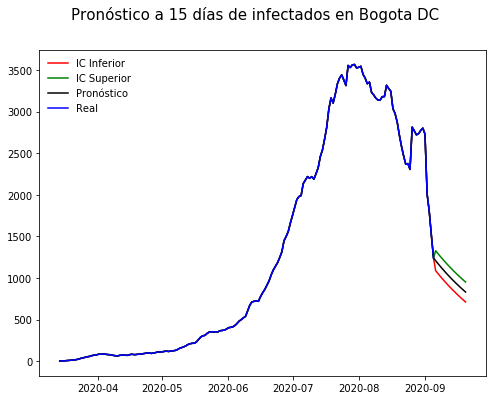

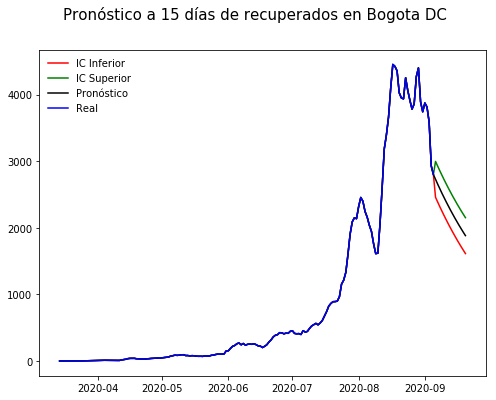

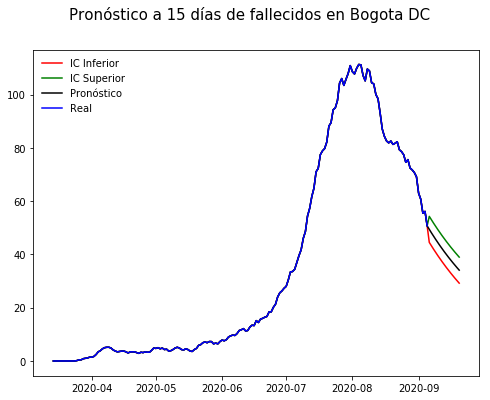

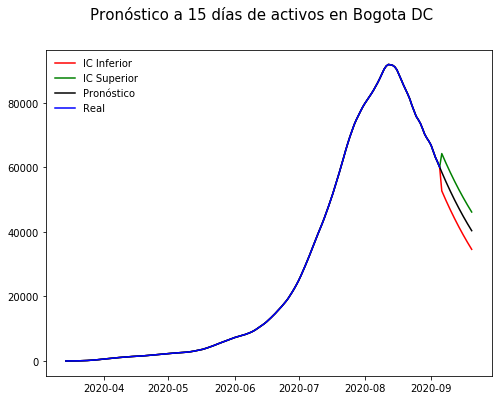

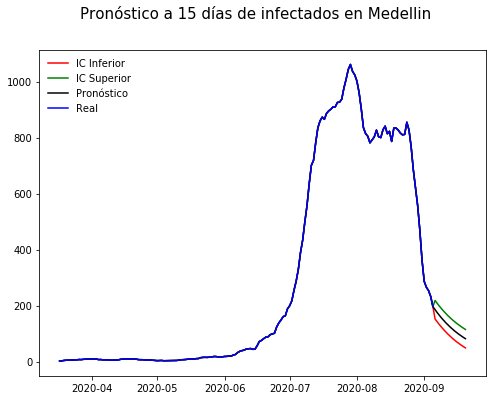

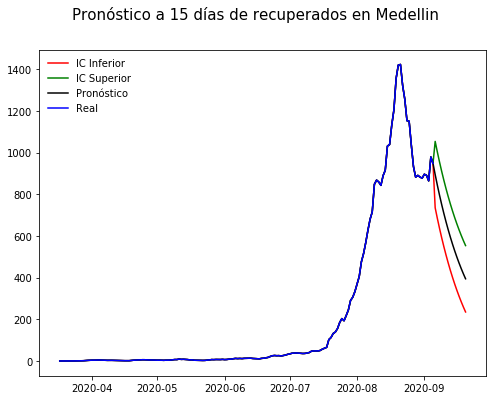

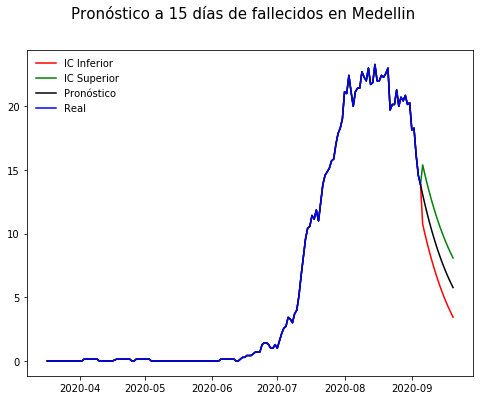

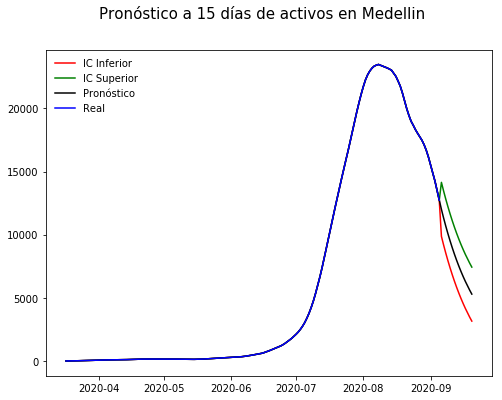

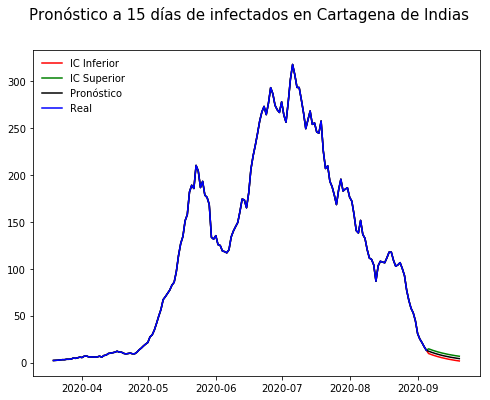

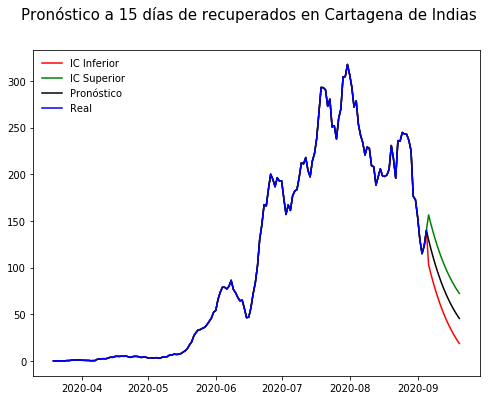

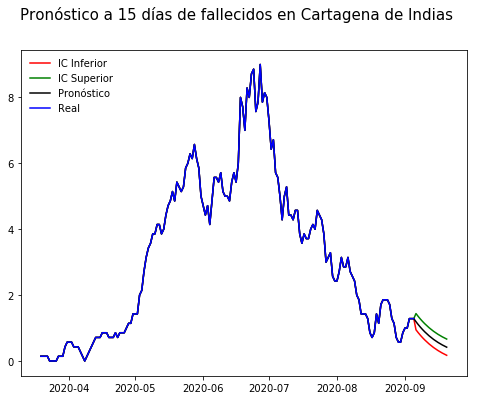

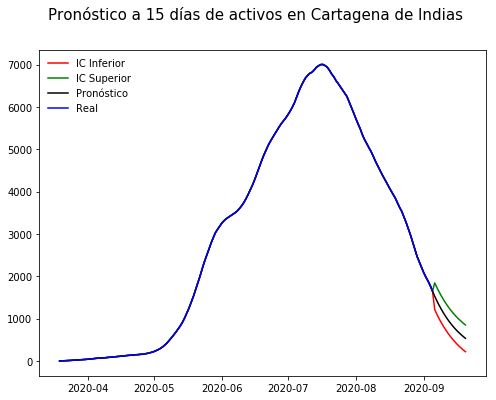

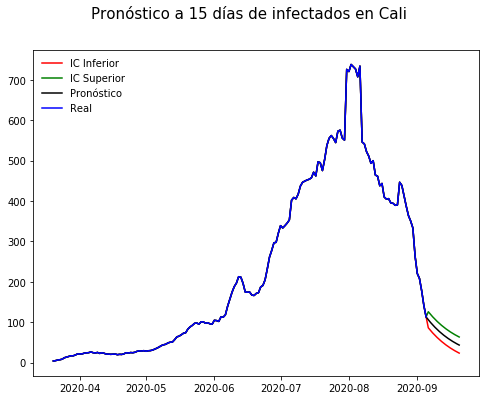

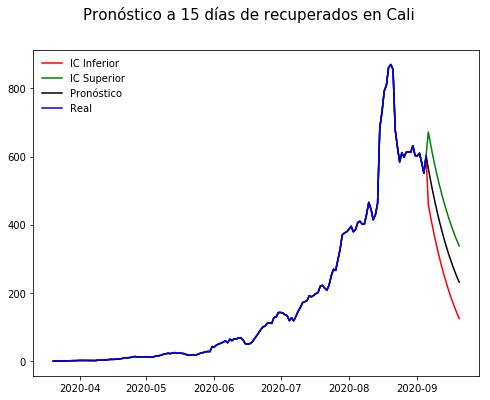

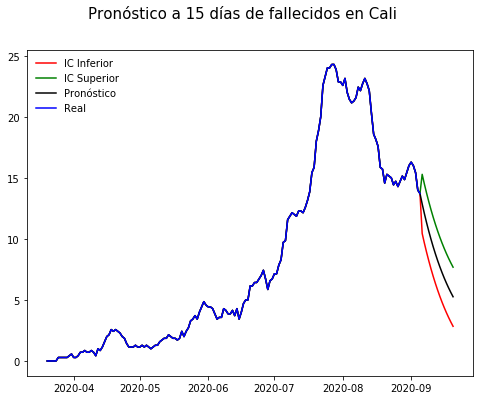

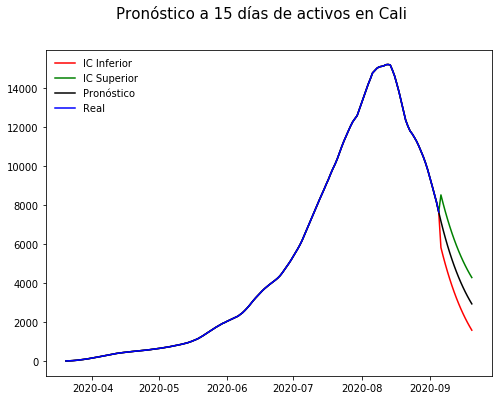

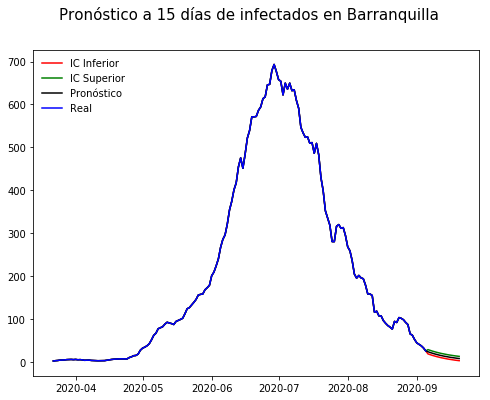

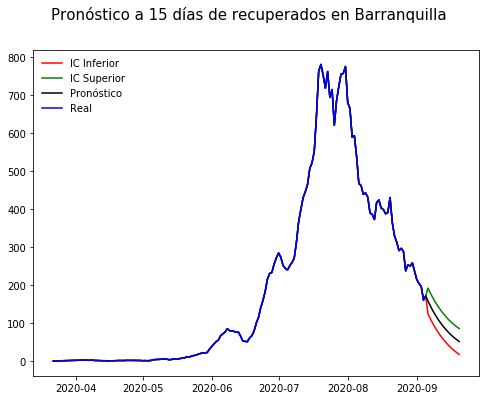

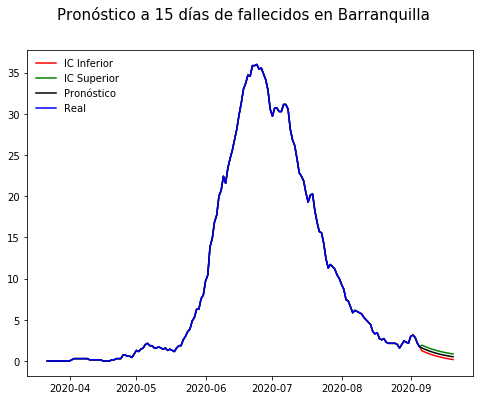

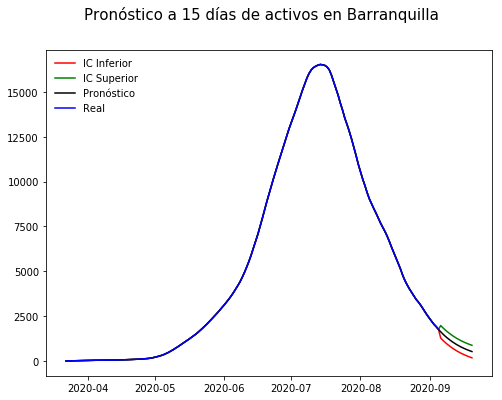

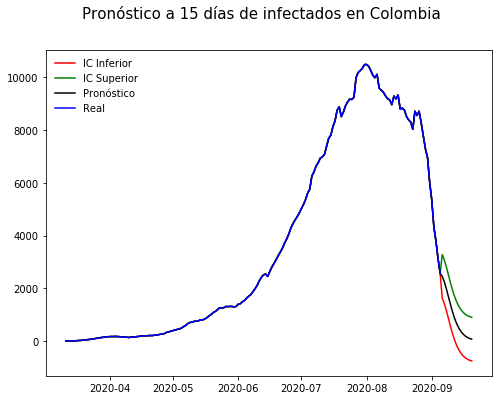

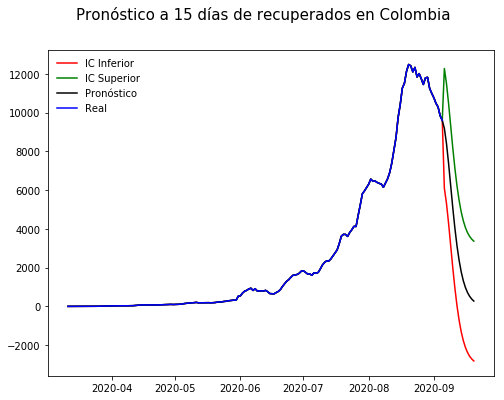

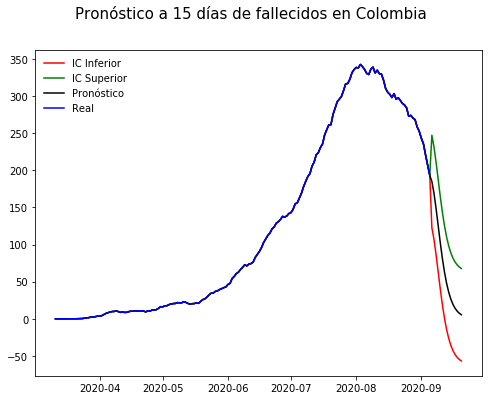

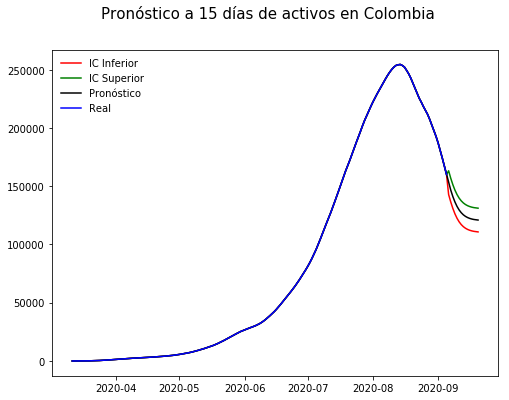

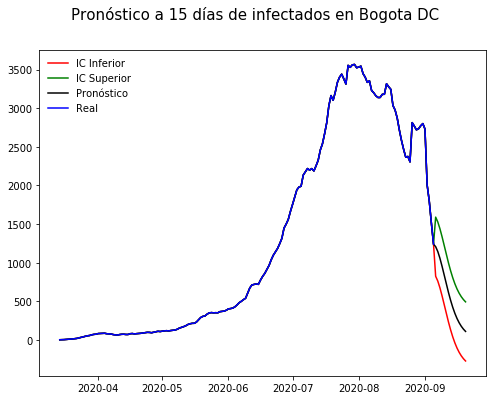

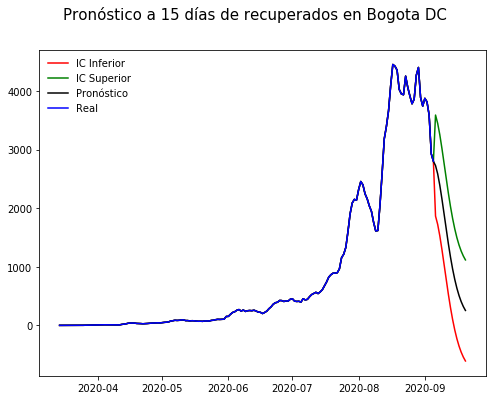

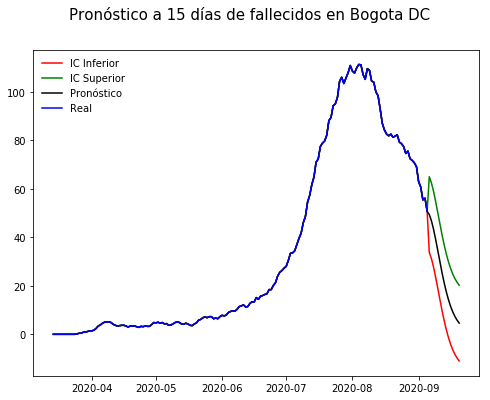

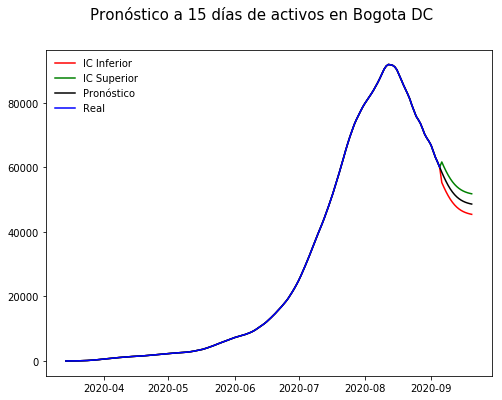

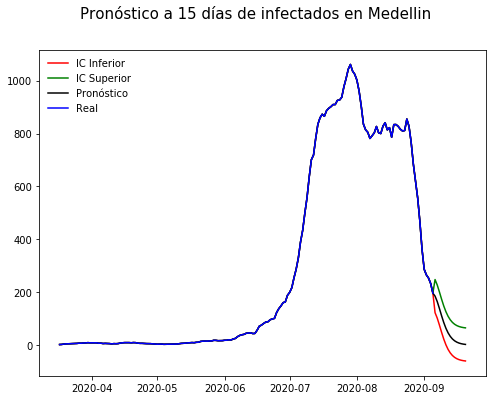

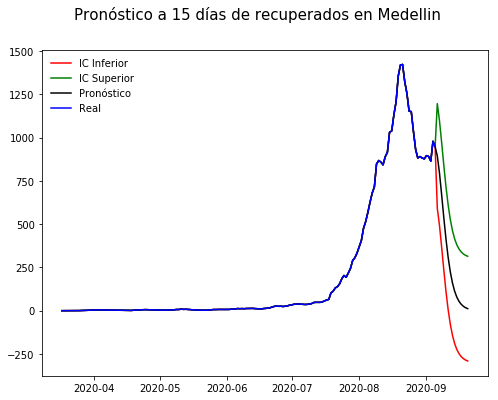

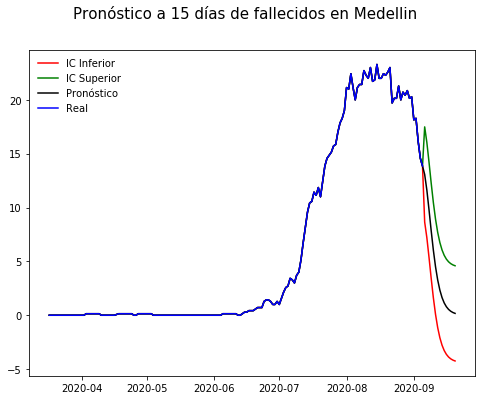

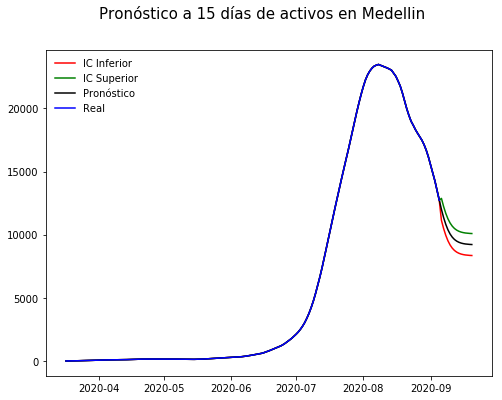

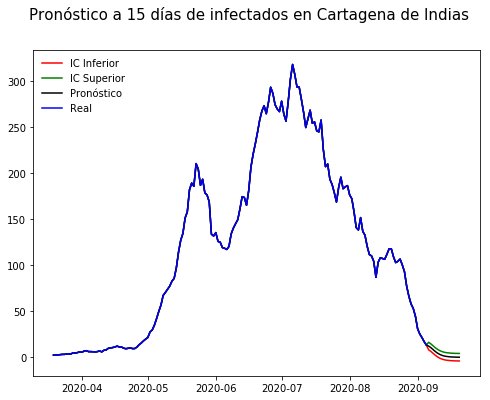

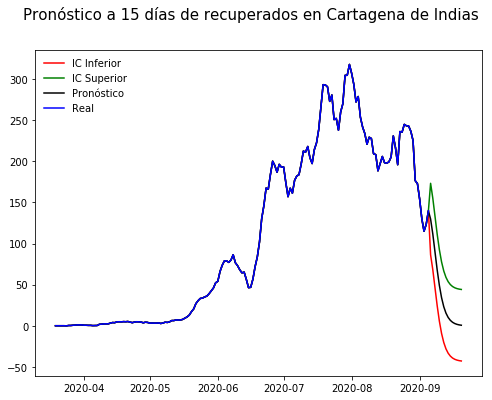

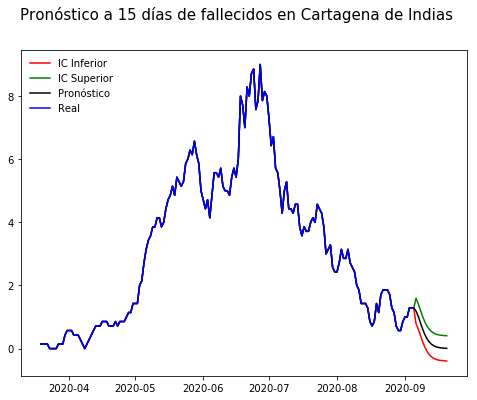

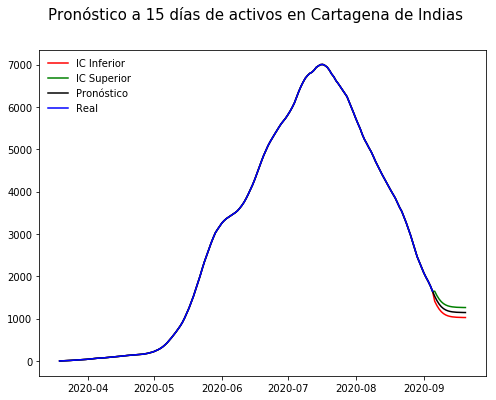

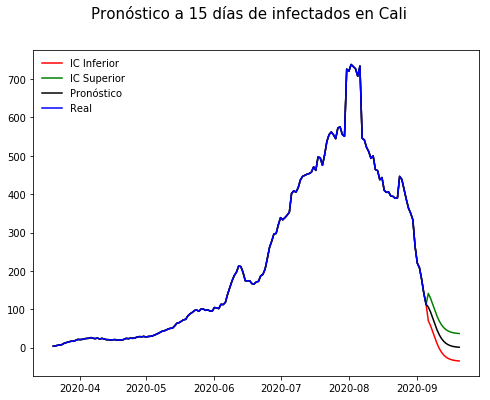

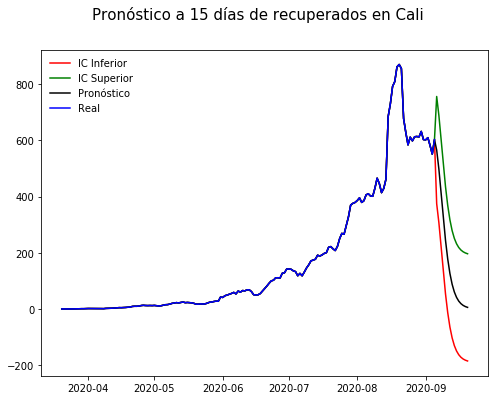

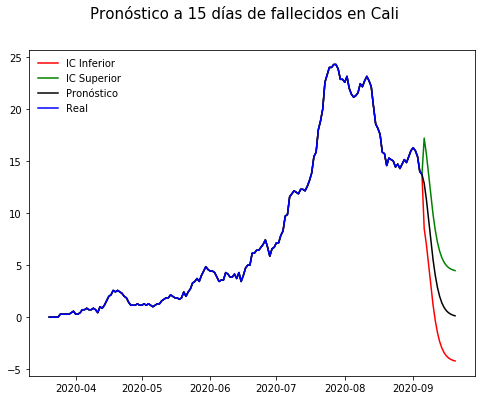

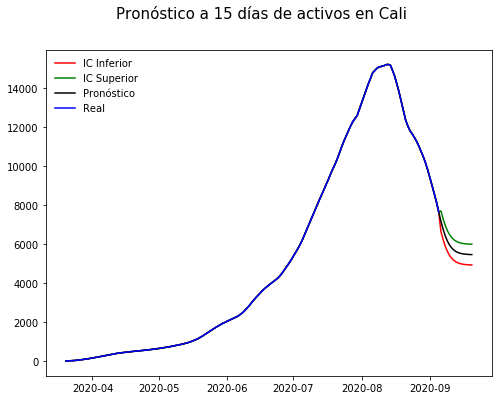

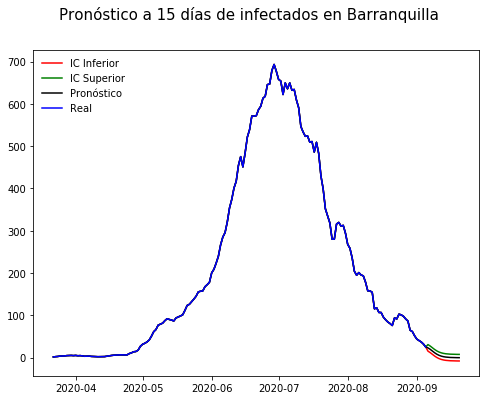

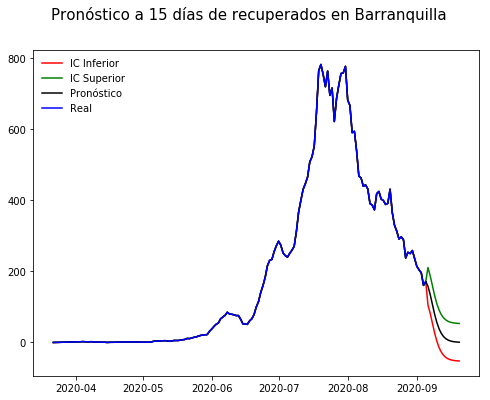

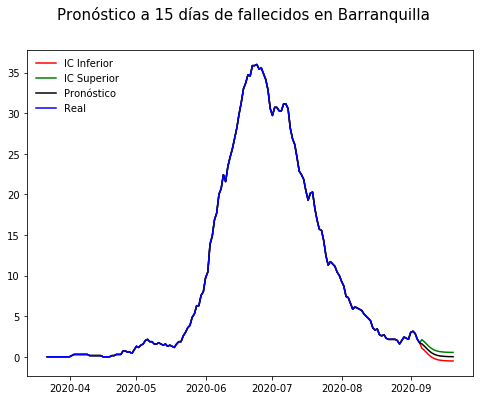

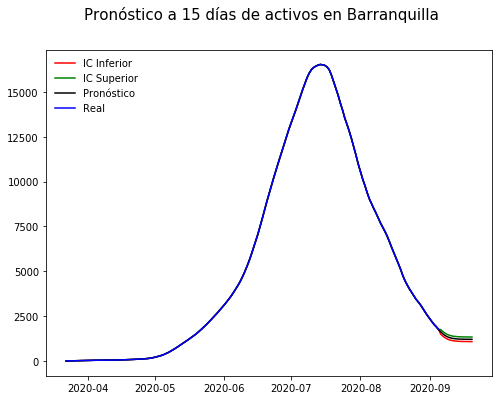

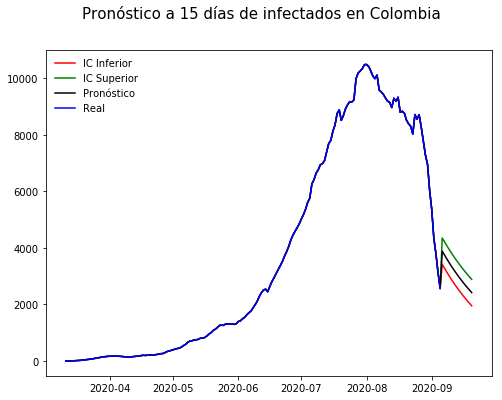

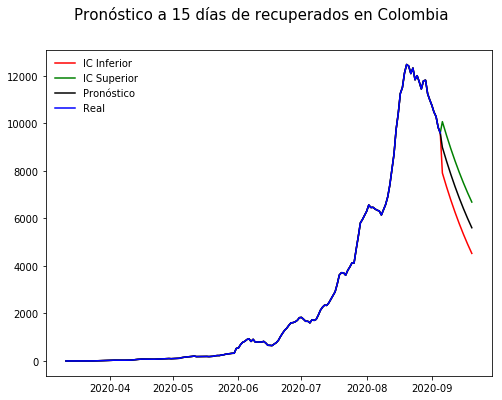

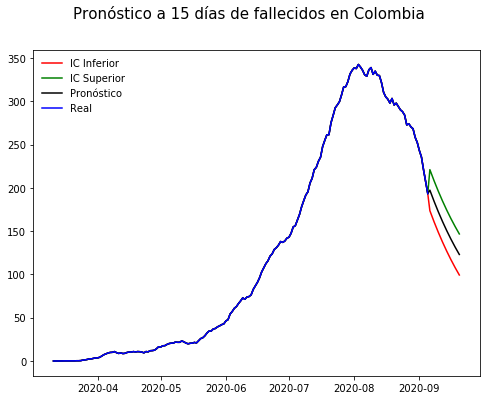

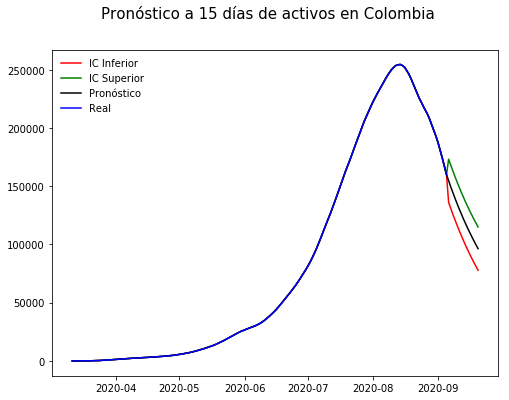

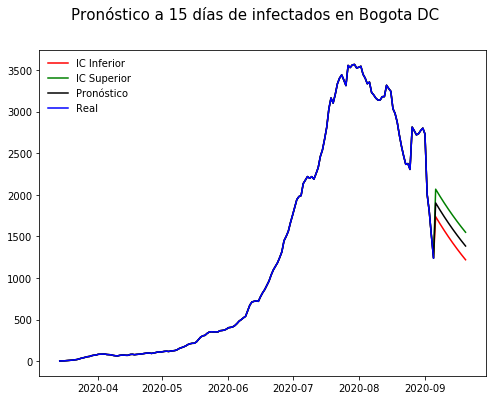

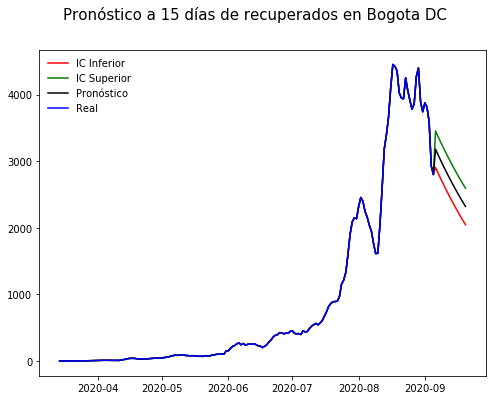

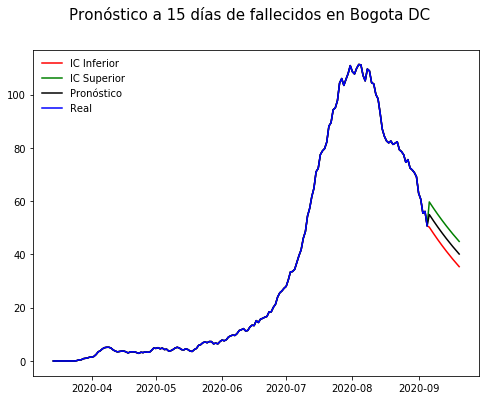

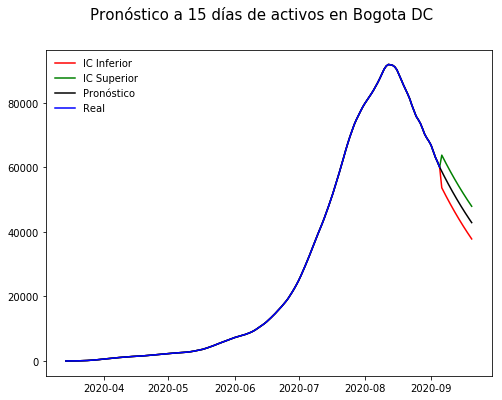

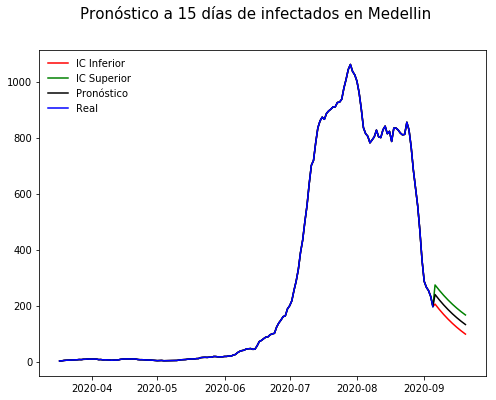

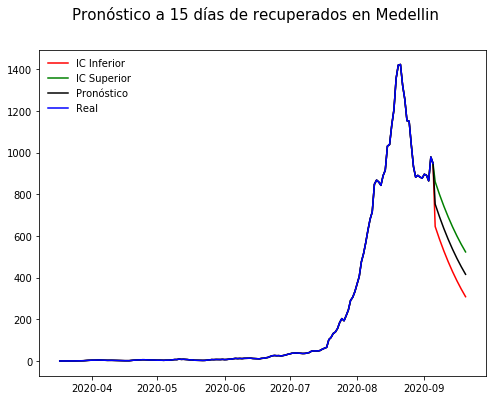

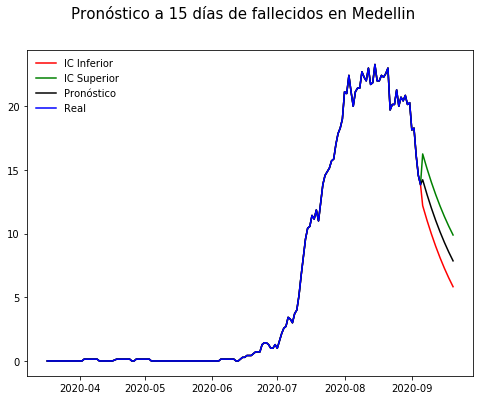

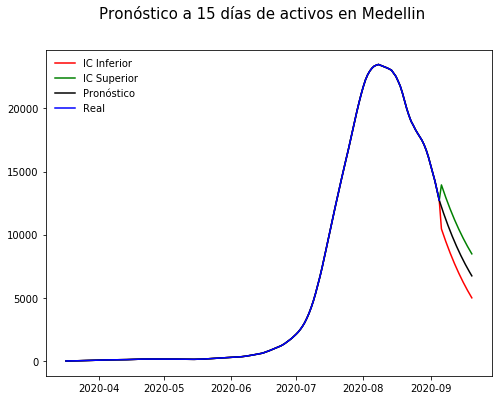

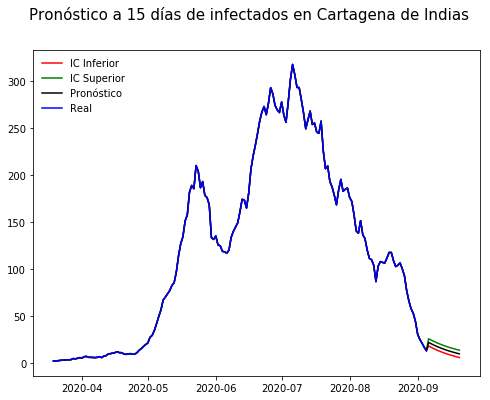

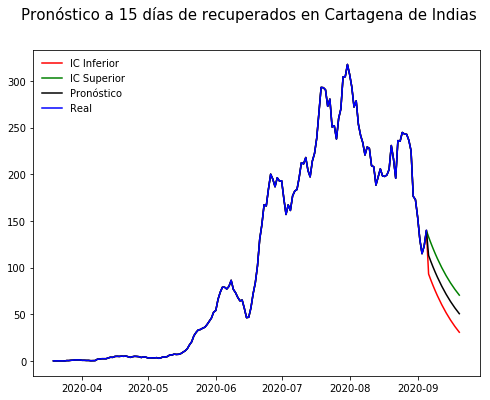

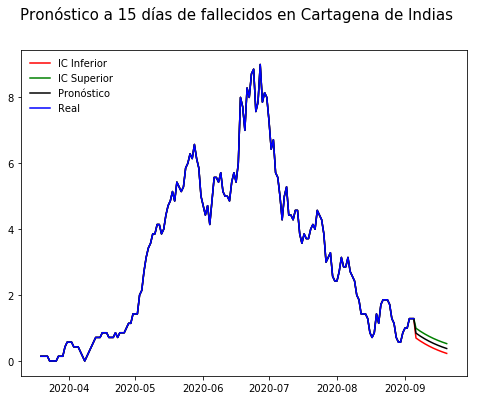

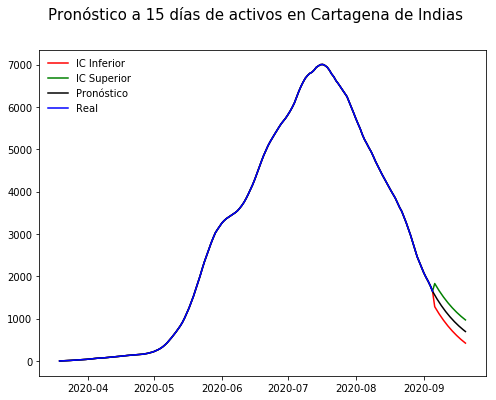

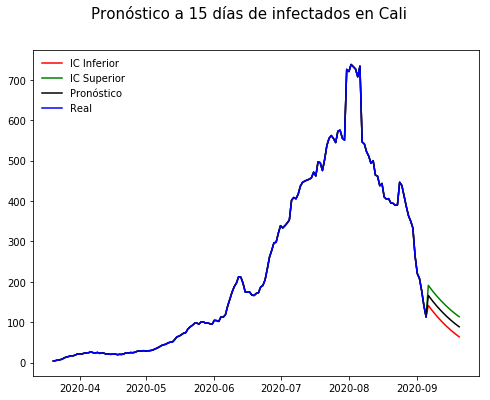

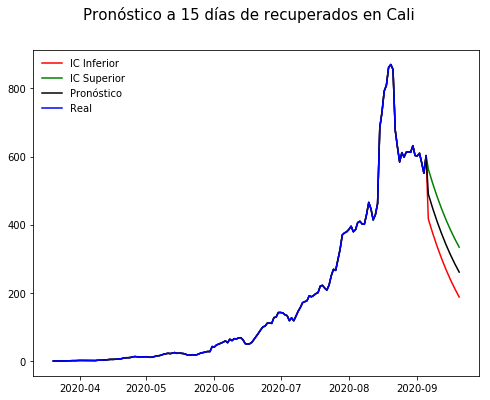

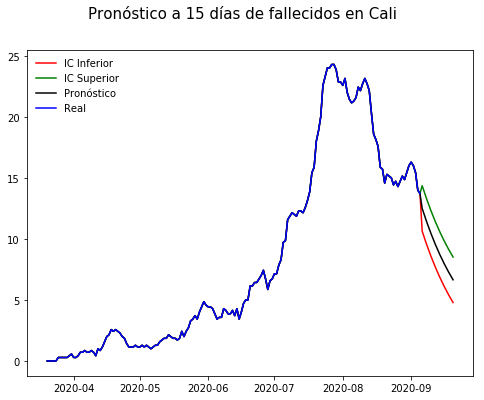

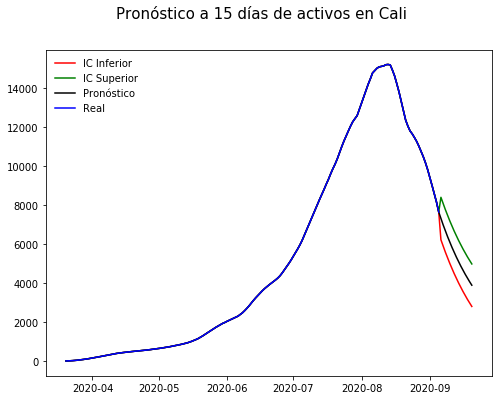

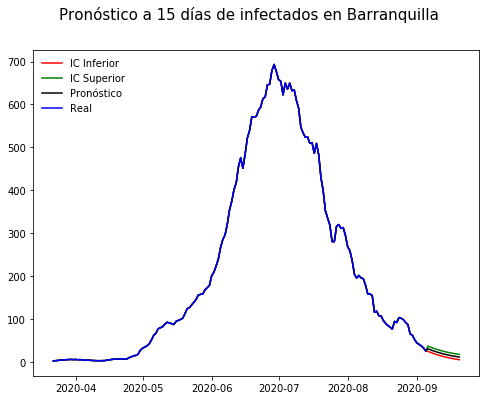

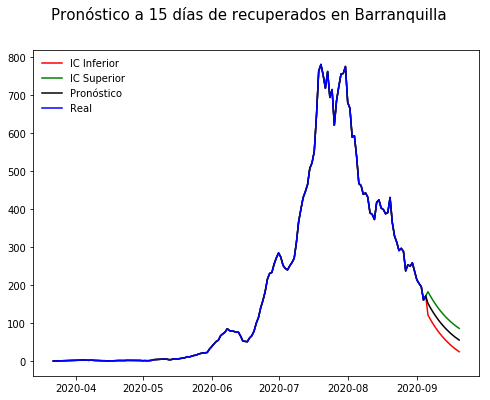

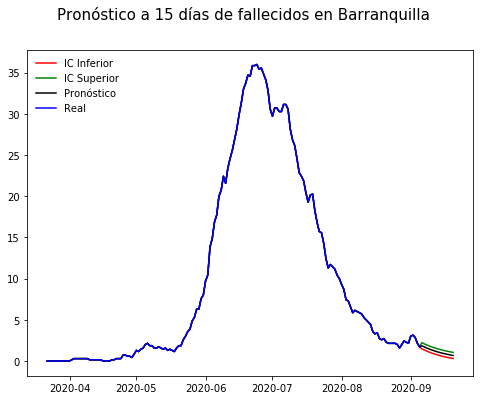

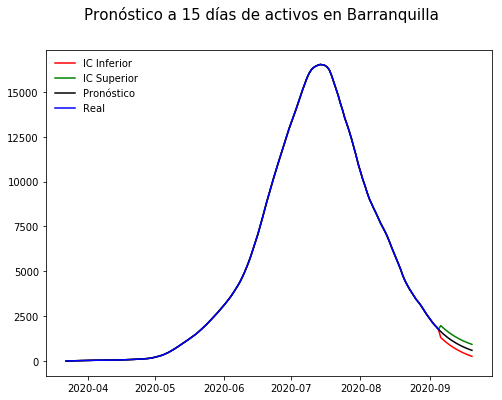

In [15]:
ciudades = ['Colombia', 'Bogota DC', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']
cal_parametros = ['last_param', 'last_param_cal', 'prom_param']
estado = ['infectados','recuperados','fallecidos','activos']
for param in cal_parametros:
    for ciudad in ciudades:
        prueba = df_pron15[(df_pron15['ciudad']== ciudad) & (df_pron15['escenario']== param)]
        
        for esta in estado:
            
            fig, ax = plt.subplots(1, figsize=(8, 6))
            fig.suptitle('Pronóstico a 15 días de ' + str(esta) + ' en ' + ciudad, fontsize=15)
            ax.plot(prueba['fecha'], prueba['ICi_'+esta], color = 'red', label="IC Inferior")
            ax.plot(prueba['fecha'], prueba['ICs_'+esta], color = 'green', label="IC Superior")
            ax.plot(prueba['fecha'], prueba['pronostico_'+esta], color='black', label="Pronóstico")
            ax.plot(prueba['fecha'], prueba[esta], color = 'blue', label='Real')
            ax.legend(loc="upper left", frameon=False)
            fig = plt.savefig('figs/' + 'pron15_' + str(esta) + "_" +str(param) + '_' + ciudad + '.png')

### Construcción de los pronósticos a 30 días y los intervalos de confianza

In [ ]:
ciudades = list(poblacion.keys())
ciudad = ['Colombia', 'Bogota DC', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']
periodo_pronostico = [15,30]
cal_parametros = ['last_param', 'last_param_cal', 'prom_param']

df_pron30 = pd.DataFrame()
for ciudad in ciudades:
    
    for param in cal_parametros:
        
        df_calculo = data_sirm_pron(df, ciudad, periodo_pronostico[1], param)
        df_calculo['ciudad'] = ciudad
        df_calculo['escenario'] = param
        df_calculo = df_calculo[['fecha','ciudad','escenario','suceptibles','infectados','recuperados','fallecidos','activos','description']]
        
        #columnas con los pronósticos
        df_calculo['pronostico_infectados'] = df_calculo['infectados']
        df_calculo['pronostico_recuperados'] = df_calculo['recuperados']
        df_calculo['pronostico_fallecidos'] = df_calculo['fallecidos']
        df_calculo['pronostico_activos'] = df_calculo['activos']
        
        df_calculo['ICi_infectados'] = df_calculo['infectados']
        df_calculo['ICs_infectados'] = df_calculo['infectados']
        df_calculo['ICi_recuperados'] = df_calculo['recuperados']
        df_calculo['ICs_recuperados'] = df_calculo['recuperados']
        df_calculo['ICi_fallecidos'] = df_calculo['fallecidos']
        df_calculo['ICs_fallecidos'] = df_calculo['fallecidos']
        df_calculo['ICi_activos'] = df_calculo['activos']
        df_calculo['ICs_activos'] = df_calculo['activos']
        
        #datos pronósticos
        df_cal1 = df_calculo.iloc[-15:,:]
        
        #datos sin pronósticos
        df_calculo = df_calculo.iloc[:-15,:]
        
        df_pron = df_calculo.iloc[:-15,:]
        
        #cálculo IC
        df_cal1['ICi_infectados'] = df_cal1['infectados'] - statistics.stdev(df_cal1['infectados'])
        df_cal1['ICs_infectados'] = df_cal1['infectados'] + statistics.stdev(df_cal1['infectados']) 
        
        df_cal1['ICi_recuperados'] = df_cal1['recuperados'] - statistics.stdev(df_cal1['recuperados'])
        df_cal1['ICs_recuperados'] = df_cal1['recuperados'] + statistics.stdev(df_cal1['recuperados'])
        
        df_cal1['ICi_fallecidos'] = df_cal1['fallecidos'] - statistics.stdev(df_cal1['fallecidos'])
        df_cal1['ICs_fallecidos'] = df_cal1['fallecidos'] + statistics.stdev(df_cal1['fallecidos'])
        
        df_cal1['ICi_activos'] = df_cal1['activos'] - statistics.stdev(df_cal1['activos'])
        df_cal1['ICs_activos'] = df_cal1['activos'] + statistics.stdev(df_cal1['activos'])
        
        df_calculo = df_calculo.append(df_cal1)
        
        # últimos valores de infectados, recuperados, fallecidos y activos
        ajuste = ['infectados','recuperados','fallecidos','activos']
        
        for f in range(len(df_calculo['infectados'][:-15]),len(df_calculo['infectados'])):
            df_calculo['infectados'][f] = None
        
        for f in range(len(df_calculo['recuperados'][:-15]),len(df_calculo['recuperados'])):
            df_calculo['recuperados'][f] = None
            
        for f in range(len(df_calculo['fallecidos'][:-15]),len(df_calculo['fallecidos'])):
            df_calculo['fallecidos'][f] = None
            
        for f in range(len(df_calculo['activos'][:-15]),len(df_calculo['activos'])):
            df_calculo['activos'][f] = None
        
        df_pron30 = pd.concat([df_pron30,df_calculo])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice f

##### Gráficas con los pronósticos a 30 días y los IC para cada uno de los estados

In [ ]:
ciudades = ['Colombia', 'Bogota DC', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']
cal_parametros = ['last_param', 'last_param_cal', 'prom_param']
estado = ['infectados','recuperados','fallecidos','activos']
for param in cal_parametros:
    for ciudad in ciudades:
        prueba = df_pron30[(df_pron30['ciudad']== ciudad) & (df_pron30['escenario']== param)]
        
        for esta in estado:
            
            fig, ax = plt.subplots(1, figsize=(8, 6))
            fig.suptitle('Pronóstico a 30 días de ' + str(esta) + ' en ' + ciudad, fontsize=15)
            ax.plot(prueba['fecha'], prueba['ICi_'+esta], color = 'red', label="IC Inferior")
            ax.plot(prueba['fecha'], prueba['ICs_'+esta], color = 'green', label="IC Superior")
            ax.plot(prueba['fecha'], prueba['pronostico_'+esta], color='black', label="Pronóstico")
            ax.plot(prueba['fecha'], prueba[esta], color = 'blue', label='Real')
            ax.legend(loc="upper left", frameon=False)
            fig = plt.savefig('figs/' + 'pron30_' + str(esta) + "_" +str(param) + '_' + ciudad + '.png')

###### Gráficas de las curvas de casos para Colombia y sus principales ciudades

<ipython-input-95-95960572c821>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-95-95960572c821>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-95-95960572c821>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


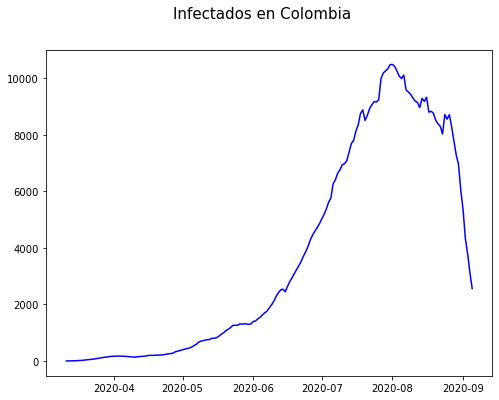

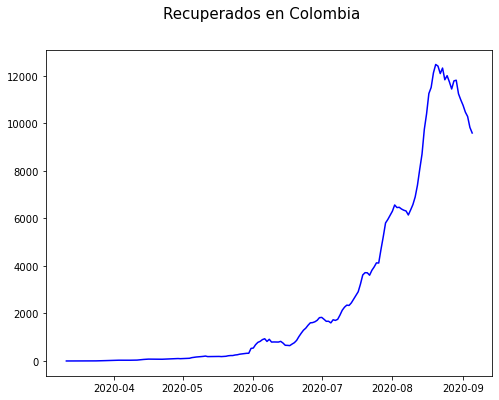

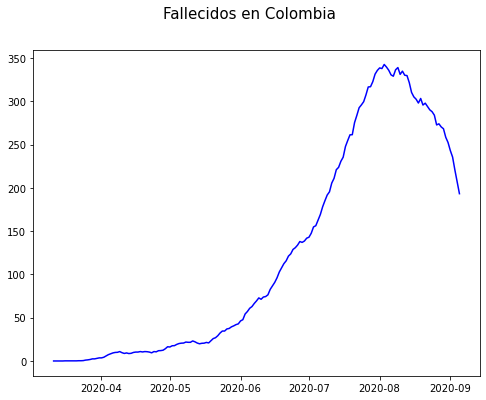

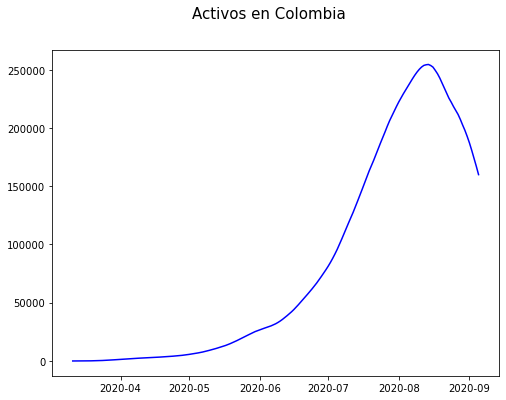

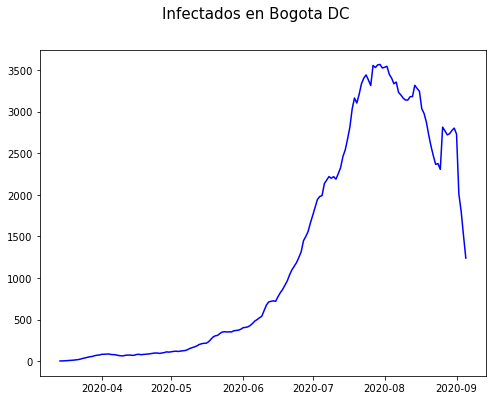

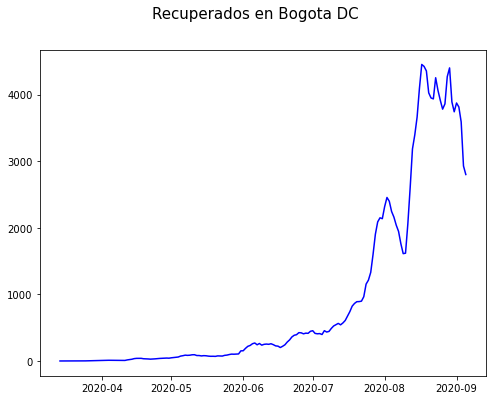

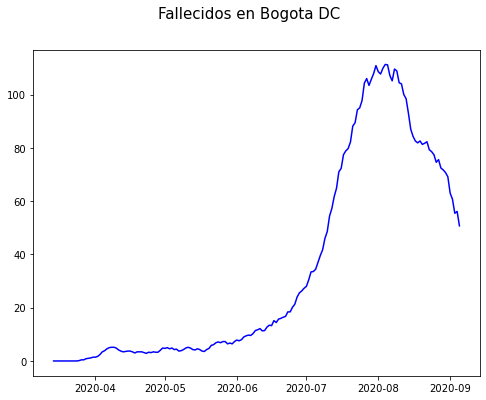

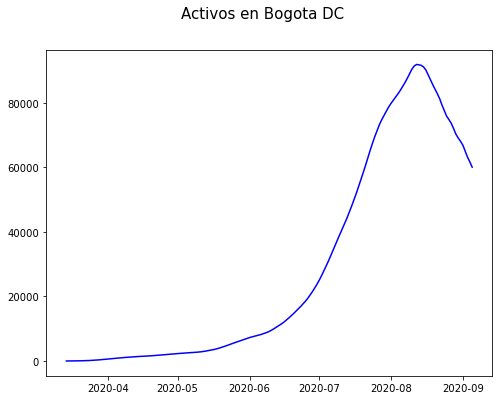

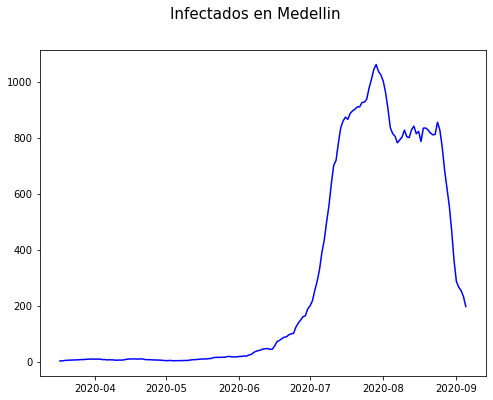

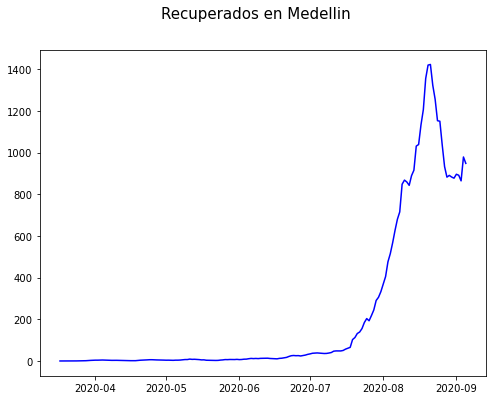

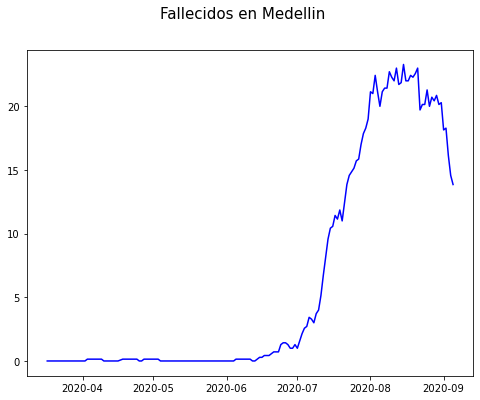

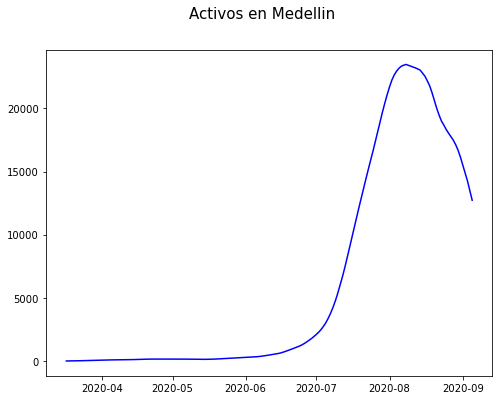

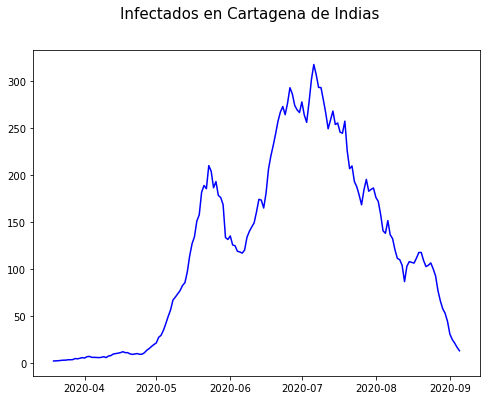

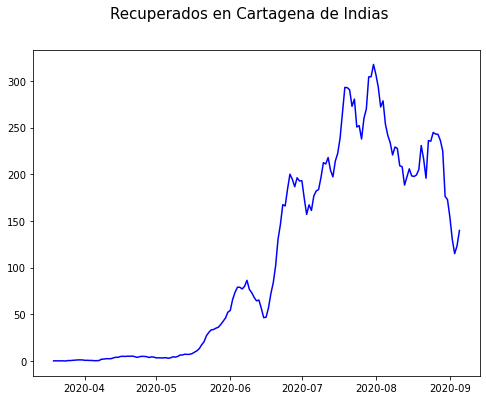

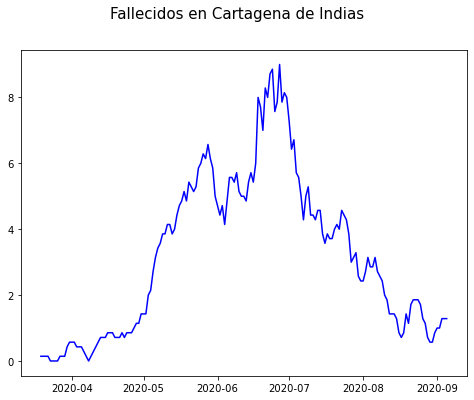

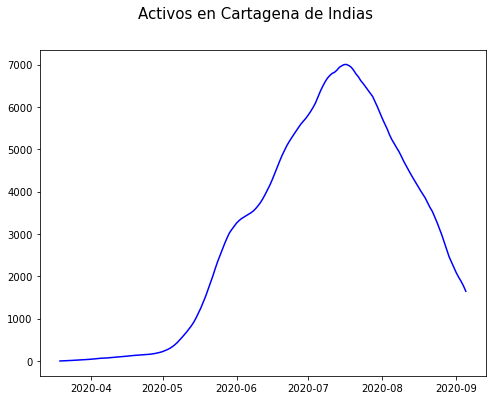

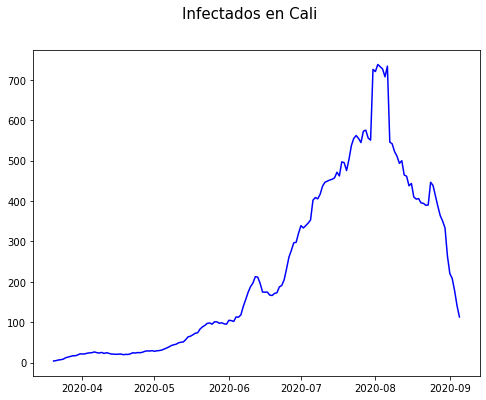

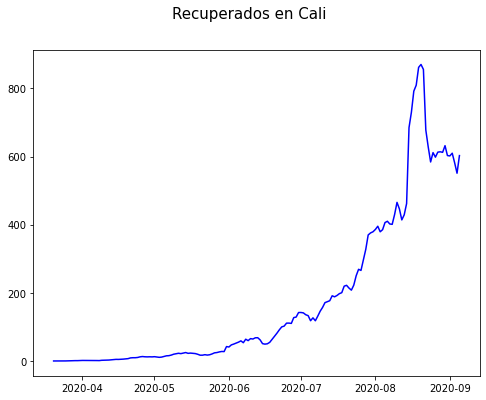

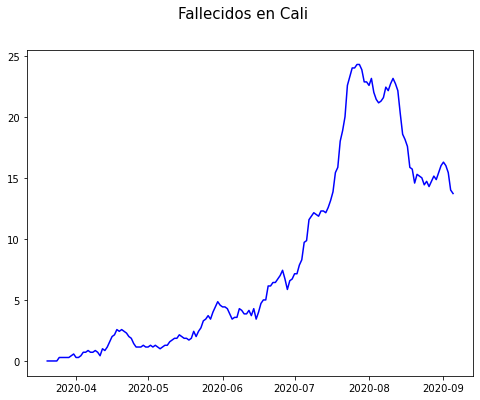

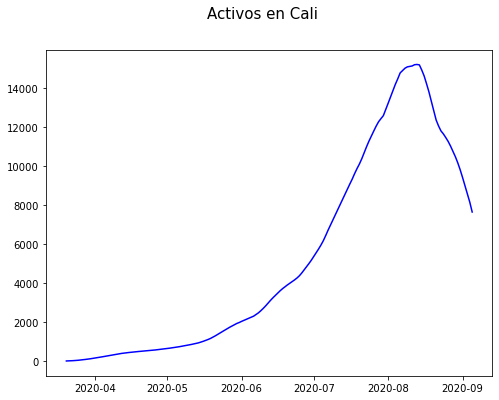

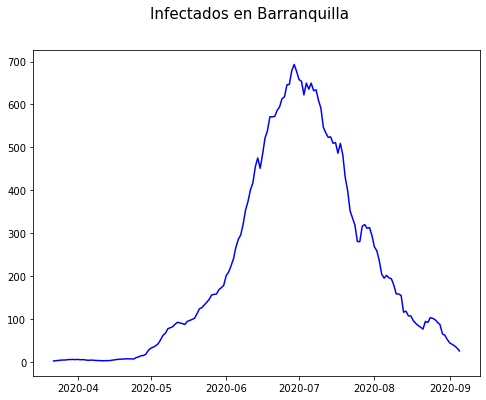

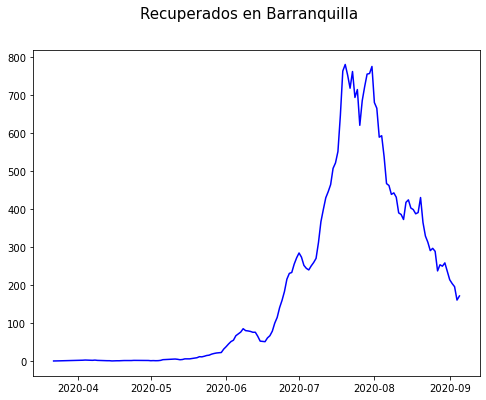

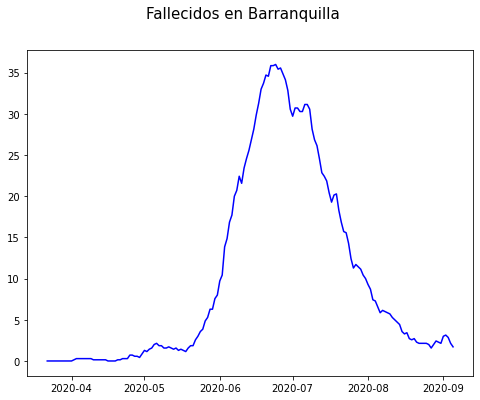

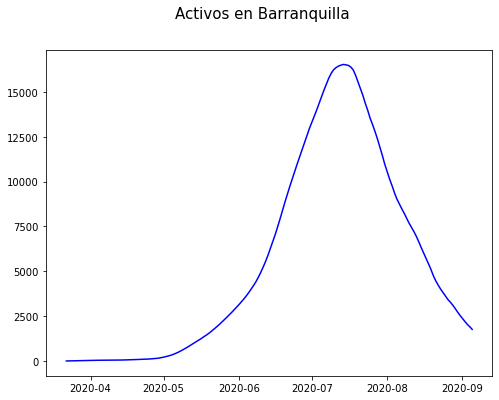

In [95]:
ciudades = ['Colombia', 'Bogota DC', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']
estado = ['infectados','recuperados','fallecidos','activos']

for ciudad in ciudades:
    prueba = df_pron15[(df_pron15['ciudad']== ciudad) & (df_pron15['escenario']== param)]

    for esta in estado:

        fig, ax = plt.subplots(1, figsize=(8, 6))
        fig.suptitle(str(esta).capitalize() + ' en ' + ciudad, fontsize=15)
        ax.plot(prueba['fecha'], prueba[esta], color = 'blue')
        fig = plt.savefig('figs/' + 'curva_casos_' + str(esta) + str(esta) + "_" + ciudad + '.png')

## Construcción de tablas resumen para guardar como imágenes

In [96]:
#Función para poner bonitas las tablas
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], Edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(Edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

#render_mpl_table(df, header_columns=0, col_width=2.0)

In [66]:
ciudades = ['Colombia', 'Bogota DC', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']

In [ ]:
# Colombia
col = df.groupby(['atencion'])['ciudad'].count()
col['Casos confirmados'] = col['Activo'] + col['Casa'] + col['Hospital'] + col['Hospital uci'] + col['Recuperado'] + col['Fallecido']
col['Casos Activos'] = col['Activo'] + col['Casa'] + col['Hospital'] + col['Hospital uci']
col = pd.DataFrame(col[['Casos confirmados','Casos Activos','Recuperado','Fallecido']]).reset_index(drop=False)
col.columns = ['Estado', 'Total']
grafica = render_mpl_table(col, header_columns=0, col_width=3.0)
grafica = plt.savefig('figs/resumen_Colombia.png')

# Bogotá DC
bog = df[df['ciudad'] == 'Bogota DC'].groupby(['atencion'])['ciudad'].count()
bog['Casos confirmados'] = bog['Activo'] + bog['Casa'] + bog['Hospital'] + bog['Hospital uci'] + bog['Recuperado'] + bog['Fallecido']
bog['Casos Activos'] = bog['Activo'] + bog['Casa'] + bog['Hospital'] + bog['Hospital uci']
bog = pd.DataFrame(bog[['Casos confirmados','Casos Activos','Recuperado','Fallecido']]).reset_index(drop=False)
bog.columns = ['Estado', 'Total']
grafica = render_mpl_table(bog, header_columns=0, col_width=3.0)
grafica = plt.savefig('figs/resumen_Bogota DC.png')

# Medellín
med = df[df['ciudad'] == 'Medellin'].groupby(['atencion'])['ciudad'].count()
med['Casos confirmados'] = med['Activo'] + med['Casa'] + med['Hospital'] + med['Hospital uci'] + med['Recuperado'] + med['Fallecido']
med['Casos Activos'] = med['Activo'] + med['Casa'] + med['Hospital'] + med['Hospital uci']
med = pd.DataFrame(med[['Casos confirmados','Casos Activos','Recuperado','Fallecido']]).reset_index(drop=False)
med.columns = ['Estado', 'Total']
grafica = render_mpl_table(med, header_columns=0, col_width=3.0)
grafica = plt.savefig('figs/resumen_Medellin.png')

# Cali
cal = df[df['ciudad'] == 'Cali'].groupby(['atencion'])['ciudad'].count()
cal['Casos confirmados'] = cal['Activo'] + cal['Casa'] + cal['Hospital'] + cal['Hospital uci'] + cal['Recuperado'] + cal['Fallecido']
cal['Casos Activos'] = cal['Activo'] + cal['Casa'] + cal['Hospital'] + cal['Hospital uci']
cal = pd.DataFrame(cal[['Casos confirmados','Casos Activos','Recuperado','Fallecido']]).reset_index(drop=False)
cal.columns = ['Estado', 'Total']
grafica = render_mpl_table(cal, header_columns=0, col_width=3.0)
grafica = plt.savefig('figs/resumen_Cali.png')

# Barranquilla
quilla = df[df['ciudad'] == 'Barranquilla'].groupby(['atencion'])['ciudad'].count()
quilla['Casos confirmados'] = quilla['Activo'] + quilla['Casa'] + quilla['Hospital'] + quilla['Hospital uci'] + quilla['Recuperado'] + quilla['Fallecido']
quilla['Casos Activos'] = quilla['Activo'] + quilla['Casa'] + quilla['Hospital'] + quilla['Hospital uci']
quilla = pd.DataFrame(quilla[['Casos confirmados','Casos Activos','Recuperado','Fallecido']]).reset_index(drop=False)
quilla.columns = ['Estado', 'Total']
grafica = render_mpl_table(quilla, header_columns=0, col_width=3.0)
grafica = plt.savefig('figs/resumen_Barranquilla.png')

# Cartagena
cart = df[df['ciudad'] == 'Cartagena de Indias'].groupby(['atencion'])['ciudad'].count()
cart['Casos confirmados'] = cart['Activo'] + cart['Casa'] + cart['Hospital'] + cart['Hospital uci'] + cart['Recuperado'] + cart['Fallecido']
cart['Casos Activos'] = cart['Activo'] + cart['Casa'] + cart['Hospital'] + cart['Hospital uci']
cart = pd.DataFrame(cart[['Casos confirmados','Casos Activos','Recuperado','Fallecido']]).reset_index(drop=False)
cart.columns = ['Estado', 'Total']
grafica = render_mpl_table(cart, header_columns=0, col_width=3.0)
grafica = plt.savefig('figs/resumen_Cartagena de Indias.png')

# Tabla resumen de los pronósticos

In [111]:
df_pron15.tail(5)

,fecha,ciudad,escenario,suceptibles,infectados,recuperados,fallecidos,activos,description,pronostico_infectados,...,pronostico_fallecidos,pronostico_activos,ICi_infectados,ICs_infectados,ICi_recuperados,ICs_recuperados,ICi_fallecidos,ICs_fallecidos,ICi_activos,ICs_activos
177,2020-09-16,Barranquilla,prom_param,1.206281e+06,NaN,NaN,NaN,NaN,Pronostico,14.693419,...,0.893141,794.788080,8.543893,20.842945,42.752569,104.263069,0.519456,1.266826,462.251420,1127.324740
178,2020-09-17,Barranquilla,prom_param,1.206267e+06,NaN,NaN,NaN,NaN,Pronostico,13.666556,...,0.830733,739.252413,7.517030,19.816081,37.616239,99.126740,0.457048,1.204418,406.715753,1071.789073
179,2020-09-18,Barranquilla,prom_param,1.206255e+06,NaN,NaN,NaN,NaN,Pronostico,12.711464,...,0.772686,687.597146,6.561938,18.860989,32.838794,94.349295,0.399001,1.146371,355.060486,1020.133806
180,2020-09-19,Barranquilla,prom_param,1.206243e+06,NaN,NaN,NaN,NaN,Pronostico,11.823125,...,0.718694,639.551167,5.673600,17.972651,28.395160,89.905660,0.345009,1.092380,307.014507,972.087827
181,2020-09-20,Barranquilla,prom_param,1.206232e+06,NaN,NaN,NaN,NaN,Pronostico,10.996875,...,0.668476,594.862302,4.847349,17.146400,24.262014,85.772514,0.294790,1.042161,262.325642,927.398962


In [116]:
df_p15 = df_pron15[['fecha','ciudad','escenario','pronostico_infectados','pronostico_recuperados','pronostico_fallecidos','pronostico_activos']]
df_p30 = df_pron30[['fecha','ciudad','escenario','pronostico_infectados','pronostico_recuperados','pronostico_fallecidos','pronostico_activos']]
df_p30.tail()

,fecha,ciudad,escenario,pronostico_infectados,pronostico_recuperados,pronostico_fallecidos,pronostico_activos
192,2020-10-01,Barranquilla,prom_param,4.956642,24.799811,0.301325,268.142250
193,2020-10-02,Barranquilla,prom_param,4.610270,23.066885,0.280269,249.405365
194,2020-10-03,Barranquilla,prom_param,4.288103,21.455048,0.260685,231.977735
195,2020-10-04,Barranquilla,prom_param,3.988450,19.955839,0.242469,215.767877
196,2020-10-05,Barranquilla,prom_param,3.709738,18.561390,0.225526,200.690699


In [121]:
df_p15 = pd.DataFrame(df_p15.groupby(['ciudad','escenario'], ).sum())
df_p15.columns = ['Caso confirmados','Recuperados','Fallecidos','Casos Activos']

Index(['pronostico_infectados', 'pronostico_recuperados',
       'pronostico_fallecidos', 'pronostico_activos'],
      dtype='object')

# Creación del dashboard de visualización con HTML

In [1]:
%%writefile DashCovidLME.html

<!doctype html>
<html lang="en">
<head>
    <!-- Required meta tags -->
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
    <!-- Bootstrap CSS -->
    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/css/bootstrap.min.css"
          integrity="sha384-ggOyR0iXCbMQv3Xipma34MD+dH/1fQ784/j6cY/iJTQUOhcWr7x9JvoRxT2MZw1T" crossorigin="anonymous">
    <title>Casos confirmados de COVID-19 en Colombia</title>

  <style>

        body {
          font-family: Arial, Helvetica, sans-serif;
          padding-left: 10px;
        }

        header {
            font-size: 20px;
        }

        nav1 {
          float: left;
          width: 13%;
          height: 120px;
          background-color: GhostWhite;
          padding: 20px;
        }
       
        section {
          float: left;
           widht:750px;
           height:450px;
           background-color: white;
        }

        aside { 
            float: right;
            widht: 185px; 
            height: 400px;
            background-color: white; 
        }
        

        .seltext {
            font-weight: bold;
        }

        .auxtext {
            font-size: 14px;
            color: #807F7F;
        }

    </style>


</head>
<body>
<h1 align="center"><strong><FONT COLOR="MidnightBlue">Casos de COVID-19 en Colombia</FONT></strong></h1>
<div class="container">
    <div class="row">             
        <div class="col-sm">
            <div class="card">
                <div class="card-body">
                  <h5 align="center"><FONT COLOR="Gray">Tendencia de pacientes confirmados, activos, recuperados y fallecidos por COVID-19 en Colombia y pronóstico de sucesos con modelo SIRM.</FONT></h5>
                  <h6 align="center"><FONT COLOR="Gray">Fuente de datos: https://www.datos.gov.co/Salud-y-Protecci-n-Social/Casos-positivos-de-COVID-19-en-Colombia/gt2j-8ykr/data</FONT></h6>
                </div>
            </div>
        </div>
    </div>
</div>

</header>
  <hr>
    <nav1 style="border:1px solid Gainsboro; border-width:2px;">
      <p class="seltext">Zona:</p><style="width:110px">
      <select id="region" name="region"  onchange="selectPlot()">
        <option value="casos_Colombia">Colombia</option>
        <option value="casos_Medellin">Medellín</option>
        <option value="casos_Bogota D.C.">Bogotá</option>
        <option value="casos_Cali">Cali</option>
        <option value="casos_Cartagena de Indias">Cartagena</option>
        <option value="casos_Barranquilla">Barranquilla</option>
      </select>
      
    </nav1>
<section>
    <div>
      <div class="myImage" id="casos_Colombia"   style="display:block"> <img src="figs/resumen_Colombia.png"  width="500" height="430"  alt="resumen_Colombia">   </div>
      <div class="myImage" id="casos_Medellin"   style="display:none">  <img src="figs/resumen_Medellin.png"  width="500" height="430"  alt="resumen_Medellin">   </div>
      <div class="myImage" id="casos_Bogota D.C."     style="display:none">  <img src="figs/resumen_Bogota DC.png"  width="500" height="430"   alt="resumen_Bogota DC">     </div>
      <div class="myImage" id="casos_Cali"   style="display:none">  <img src="figs/resumen_Cali.png"  width="500" height="430"  alt="resumen_Cali">   </div>
      <div class="myImage" id="casos_Cartagena de Indias"  style="display:none">  <img src="figs/resumen_Cartagena de Indias.png"  width="500" height="430"  alt="resumen_Cartagena de Indias">  </div>
      <div class="myImage" id="casos_Barranquilla"   style="display:none">  <img src="figs/resumen_Barranquilla.png"  width="500" height="430"  alt="resumen_Barranquilla">   </div>      
    </div>
    <div>
      <div class="myImage" id="casos_Colombia"   style="display:block"> <img src="figs/pron15_infectados_last_param_Colombia.png"   alt="pron15_infectados_last_param_Colombia">   </div>
      <div class="myImage" id="casos_Medellin"   style="display:none">  <img src="figs/pron15_infectados_last_param_Medellin.png"   alt="pron15_infectados_last_param_Medellin">   </div>
      <div class="myImage" id="casos_Bogota D.C."     style="display:none">  <img src="figs/pron15_infectados_last_param_Bogota DC.png"     alt="pron15_infectados_last_param_Bogota DC">     </div>
      <div class="myImage" id="casos_Cali"   style="display:none">  <img src="figs/pron15_infectados_last_param_Cali.png"   alt="pron15_infectados_last_param_Cali">   </div>
      <div class="myImage" id="casos_Cartagena de Indias"  style="display:none">  <img src="figs/pron15_infectados_last_param_Cartagena de Indias.png"  alt="pron15_infectados_last_param_Cartagena de Indias">  </div>
      <div class="myImage" id="casos_Barranquilla"   style="display:none">  <img src="figs/pron15_infectados_last_param_Barranquilla.png"   alt="pron15_infectados_last_param_Barranquilla">   </div>      
    </div>
    <div>
      <div class="myImage" id="casos_Colombia"   style="display:block"> <img src="figs/pron15_activos_last_param_Colombia.png"   alt="pron15_activos_last_param_Colombia">   </div>
      <div class="myImage" id="casos_Medellin"   style="display:none">  <img src="figs/pron15_activos_last_param_Medellin.png"   alt="pron15_activos_last_param_Medellin">   </div>
      <div class="myImage" id="casos_Bogota D.C."     style="display:none">  <img src="figs/pron15_activos_last_param_Bogota DC.png"     alt="pron15_activos_last_param_Bogota DC">     </div>
      <div class="myImage" id="casos_Cali"   style="display:none">  <img src="figs/pron15_activos_last_param_Cali.png"   alt="pron15_activos_last_param_Cali">   </div>
      <div class="myImage" id="casos_Cartagena de Indias"  style="display:none">  <img src="figs/pron15_activos_last_param_Cartagena de Indias.png"  alt="pron15_activos_last_param_Cartagena de Indias">  </div>
      <div class="myImage" id="casos_Barranquilla"   style="display:none">  <img src="figs/pron15_activos_last_param_Barranquilla.png"   alt="pron15_activos_last_param_Barranquilla">   </div>
    </div>
    <div>
      <div class="myImage" id="casos_Colombia"   style="display:block"> <img src="figs/pron15_recuperados_last_param_Colombia.png"   alt="pron15_recuperados_last_param_Colombia">   </div>
      <div class="myImage" id="casos_Medellin"   style="display:none">  <img src="figs/pron15_recuperados_last_param_Medellin.png"   alt="pron15_recuperados_last_param_Medellin">   </div>
      <div class="myImage" id="casos_Bogota D.C."     style="display:none">  <img src="figs/pron15_recuperados_last_param_Bogota DC.png"     alt="pron15_recuperados_last_param_Bogota DC">     </div>
      <div class="myImage" id="casos_Cali"   style="display:none">  <img src="figs/pron15_recuperados_last_param_Cali.png"   alt="pron15_recuperados_last_param_Cali">   </div>
      <div class="myImage" id="casos_Cartagena de Indias"  style="display:none">  <img src="figs/pron15_recuperados_last_param_Cartagena de Indias.png"  alt="pron15_recuperados_last_param_Cartagena de Indias">  </div>
      <div class="myImage" id="casos_Barranquilla"   style="display:none">  <img src="figs/pron15_recuperados_last_param_Barranquilla.png"   alt="pron15_recuperados_last_param_Barranquilla">   </div>
    </div>
    <div>
      <div class="myImage" id="casos_Colombia"   style="display:block"> <img src="figs/pron15_fallecidos_last_param_Colombia.png"   alt="pron15_fallecidos_last_param_Colombia">   </div>
      <div class="myImage" id="casos_Medellin"   style="display:none">  <img src="figs/pron15_fallecidos_last_param_Medellin.png"   alt="pron15_fallecidos_last_param_Medellin">   </div>
      <div class="myImage" id="casos_Bogota D.C."     style="display:none">  <img src="figs/pron15_fallecidos_last_param_Bogota DC.png"    alt="pron15_fallecidos_last_param_Bogota DC">     </div>
      <div class="myImage" id="casos_Cali"   style="display:none">  <img src="figs/pron15_fallecidos_last_param_Cali.png"   alt="pron15_fallecidos_last_param_Cali">   </div>
      <div class="myImage" id="casos_Cartagena de Indias"  style="display:none">  <img src="figs/pron15_fallecidos_last_param_Cartagena de Indias.png"    alt="pron15_fallecidos_last_param_Cartagena de Indias">  </div>
      <div class="myImage" id="casos_Barranquilla"   style="display:none">  <img src="figs/pron15_fallecidos_last_param_Barranquilla.png"    alt="pron15_fallecidos_last_param_Barranquilla">   </div>
    </div>
</section>

<aside>
    <div>
      <div class="myImage" id="casos_Colombia"   style="display:block"> <img src="figs/curva_casos_infectadosinfectados_Colombia.png"   alt="curva_casos_infectadosinfectados_Colombia">   </div>
      <div class="myImage" id="casos_Medellin"   style="display:none">  <img src="figs/curva_casos_infectadosinfectados_Medellin.png"   alt="curva_casos_infectadosinfectados_Medellin">   </div>
      <div class="myImage" id="casos_Bogota D.C."     style="display:none">  <img src="figs/curva_casos_infectadosinfectados_Bogota DC.png"    alt="curva_casos_infectadosinfectados_Bogota DC">     </div>
      <div class="myImage" id="casos_Cali"   style="display:none">  <img src="figs/curva_casos_infectadosinfectados_Cali.png"   alt="curva_casos_infectadosinfectados_Cali">   </div>
      <div class="myImage" id="casos_Cartagena de Indias"  style="display:none">  <img src="figs/curva_casos_infectadosinfectados_Cartagena de Indias.png"    alt="curva_casos_infectadosinfectados_Cartagena de Indias">  </div>
      <div class="myImage" id="casos_Barranquilla"   style="display:none">  <img src="figs/curva_casos_infectadosinfectados_Barranquilla.png"    alt="curva_casos_infectadosinfectados_Barranquilla">   </div>
    </div>
    <div>
      <div class="myImage" id="casos_Colombia"   style="display:block"> <img src="figs/pron30_infectados_last_param_Colombia.png"   alt="pron30_infectados_last_param_Colombia">   </div>
      <div class="myImage" id="casos_Medellin"   style="display:none">  <img src="figs/pron30_infectados_last_param_Medellin.png"   alt="pron30_infectados_last_param_Medellin">   </div>
      <div class="myImage" id="casos_Bogota D.C."     style="display:none">  <img src="figs/pron30_infectados_last_param_Bogota DC.png"    alt="pron30_infectados_last_param_Bogota DC">     </div>
      <div class="myImage" id="casos_Cali"   style="display:none">  <img src="figs/pron30_infectados_last_param_Cali.png"   alt="pron30_infectados_last_param_Cali">   </div>
      <div class="myImage" id="casos_Cartagena de Indias"  style="display:none">  <img src="figs/pron30_infectados_last_param_Cartagena de Indias.png"    alt="pron30_infectados_last_param_Cartagena de Indias">  </div>
      <div class="myImage" id="casos_Barranquilla"   style="display:none">  <img src="figs/pron30_infectados_last_param_Barranquilla.png"    alt="pron30_infectados_last_param_Barranquilla">   </div>
    </div>
    <div>
      <div class="myImage" id="casos_Colombia"   style="display:block"> <img src="figs/pron30_activos_last_param_Colombia.png"   alt="pron30_activos_last_param_Colombia">   </div>
      <div class="myImage" id="casos_Medellin"   style="display:none">  <img src="figs/pron30_activos_last_param_Medellin.png"   alt="pron30_activos_last_param_Medellin">   </div>
      <div class="myImage" id="casos_Bogota D.C."     style="display:none">  <img src="figs/pron30_activos_last_param_Bogota DC.png"     alt="pron30_activos_last_param_Bogota DC">     </div>
      <div class="myImage" id="casos_Cali"   style="display:none">  <img src="figs/pron30_activos_last_param_Cali.png"   alt="pron30_activos_last_param_Cali">   </div>
      <div class="myImage" id="casos_Cartagena de Indias"  style="display:none">  <img src="figs/pron30_activos_last_param_Cartagena de Indias.png"  alt="pron30_activos_last_param_Cartagena de Indias">  </div>
      <div class="myImage" id="casos_Barranquilla"   style="display:none">  <img src="figs/pron30_activos_last_param_Barranquilla.png"   alt="pron30_activos_last_param_Barranquilla">   </div>
    </div>
    <div>
      <div class="myImage" id="casos_Colombia"   style="display:block"> <img src="figs/pron30_recuperados_last_param_Colombia.png"   alt="pron30_recuperados_last_param_Colombia">   </div>
      <div class="myImage" id="casos_Medellin"   style="display:none">  <img src="figs/pron30_recuperados_last_param_Medellin.png"   alt="pron30_recuperados_last_param_Medellin">   </div>
      <div class="myImage" id="casos_Bogota D.C."     style="display:none">  <img src="figs/pron30_recuperados_last_param_Bogota DC.png"     alt="pron30_recuperados_last_param_Bogota DC">     </div>
      <div class="myImage" id="casos_Cali"   style="display:none">  <img src="figs/pron30_recuperados_last_param_Cali.png"   alt="pron30_recuperados_last_param_Cali">   </div>
      <div class="myImage" id="casos_Cartagena de Indias"  style="display:none">  <img src="figs/pron30_recuperados_last_param_Cartagena de Indias.png"  alt="pron30_recuperados_last_param_Cartagena de Indias">  </div>
      <div class="myImage" id="casos_Barranquilla"   style="display:none">  <img src="figs/pron30_recuperados_last_param_Barranquilla.png"   alt="pron30_recuperados_last_param_Barranquilla">   </div>
    </div>
    <div>
      <div class="myImage" id="casos_Colombia"   style="display:block"> <img src="figs/pron30_fallecidos_last_param_Colombia.png"   alt="pron30_fallecidos_last_param_Colombia">   </div>
      <div class="myImage" id="casos_Medellin"   style="display:none">  <img src="figs/pron30_fallecidos_last_param_Medellin.png"   alt="pron30_fallecidos_last_param_Medellin">   </div>
      <div class="myImage" id="casos_Bogota D.C."     style="display:none">  <img src="figs/pron30_fallecidos_last_param_Bogota DC.png"    alt="pron30_fallecidos_last_param_Bogota DC">     </div>
      <div class="myImage" id="casos_Cali"   style="display:none">  <img src="figs/pron30_fallecidos_last_param_Cali.png"   alt="pron30_fallecidos_last_param_Cali">   </div>
      <div class="myImage" id="casos_Cartagena de Indias"  style="display:none">  <img src="figs/pron30_fallecidos_last_param_Cartagena de Indias.png"    alt="pron30_fallecidos_last_param_Cartagena de Indias">  </div>
      <div class="myImage" id="casos_Barranquilla"   style="display:none">  <img src="figs/pron30_fallecidos_last_param_Barranquilla.png"    alt="pron30_fallecidos_last_param_Barranquilla">   </div>
    </div>
</aside>

    <script>
      function selectPlot() {
        var region = document.getElementById("region").value;
        var images = document.getElementsByClassName("myImage");
        for (var i = 0; i < images.length; i++) {
          if (images[i].id == region) {
            images[i].style.display = "block"
          }else{
            images[i].style.display = "none"
          }
        }
      }
    </script>
  
</body>
</html>

Writing DashCovidLME.html
